In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
np.random.seed(123)
solvers.options['show_progress'] = False

In [3]:
df = pd.read_csv('out.csv', sep=' ')
#df_serie = df.transpose()[0]

In [3]:
#list(df['preTestScore'].groupby(df['regiment']))
gb_symbol = df['f_open'].groupby(df['symbol'])
des_gbs = gb_symbol.describe()
name_stocks = []
n_count = 246
for i in range(len(list(gb_symbol))):
    if len(list(gb_symbol)[i][1]) >= n_count:
#        name_stocks.append([list(gb_symbol)[i][0],len(list(gb_symbol)[i][1])])
        name_stocks.append(list(gb_symbol)[i][0])
#        print(len(list(gb_symbol)[i][1]))
#type(des_gbs)
#des_gbs[des_gbs.eval('count') > 200]
#des_gbs.count
#gb.first()
#gb.get_group('AALR3').values[:,1]

In [4]:
df_raw_data = pd.DataFrame(columns = name_stocks)

In [5]:
df_raw_data

,AALR3,ABCB4,ABCP11,ABEV3,AEFI11,AGCX11,AGRO3,ALPA4,ALSC3,ALUP11,...,VIVR3,VIVT3,VIVT4,VLID3,VRTA11,VULC3,VVAR11,VVAR4,WEGE3,XPCM11


In [6]:
rem_names = []
for name in name_stocks:
    stop = 0
    l = gb_symbol.get_group(name).values
    for ll in l:
        if int(ll)==0:
#            print("error",name)
            rem_names.append(name)
#            df_raw_data.drop(columns=[name])
            stop = 1
    l_dif = np.diff(l)
    if name[-1]!='3' or stop == 1:
#        print(name)
        rem_names.append(name)
        continue
#    for ll in l:
#        if int(ll)>10:
#            rem_names.append(name)
#            break
    df_raw_data[name] = [np.log(x/y+1) for x, y in zip(l_dif, l)]
#rem_names
#df_raw_data['AALR3'] = np.diff(gb.get_group('AALR3').values[:,1])
#gb_symbol.get_group('AALR3').values
#type(np.diff(gb.get_group('AALR3').values[:,1]))

13        14.41
398       14.71
849       14.92
1298      15.26
1725      15.35
2137      15.23
2584      15.09
3001      15.01
3440      15.98
3870      15.92
4298      15.67
4718      15.38
5206      14.94
5641      14.59
6070      14.69
6494      15.10
6965      15.35
7437      15.33
7936      15.28
8382      15.17
8862      15.00
9338      15.09
9805      14.92
10265     14.99
10768     15.36
11260     14.93
11756     14.74
12200     15.34
12638     15.60
13082     15.58
          ...  
99357     16.42
99854     16.21
100327    16.85
100839    16.87
101360    17.22
101834    17.30
102261    17.27
102739    17.66
103265    17.17
103787    17.33
104242    17.02
104707    16.97
105212    17.02
105718    17.40
106170    17.30
106634    17.15
107083    17.12
107544    17.02
108048    17.11
108539    17.48
109011    16.98
109479    17.05
109996    17.28
110502    17.11
110980    17.11
111452    17.28
111924    17.49
112428    17.46
112950    17.62
113429    17.75
Name: f_open, Length: 24

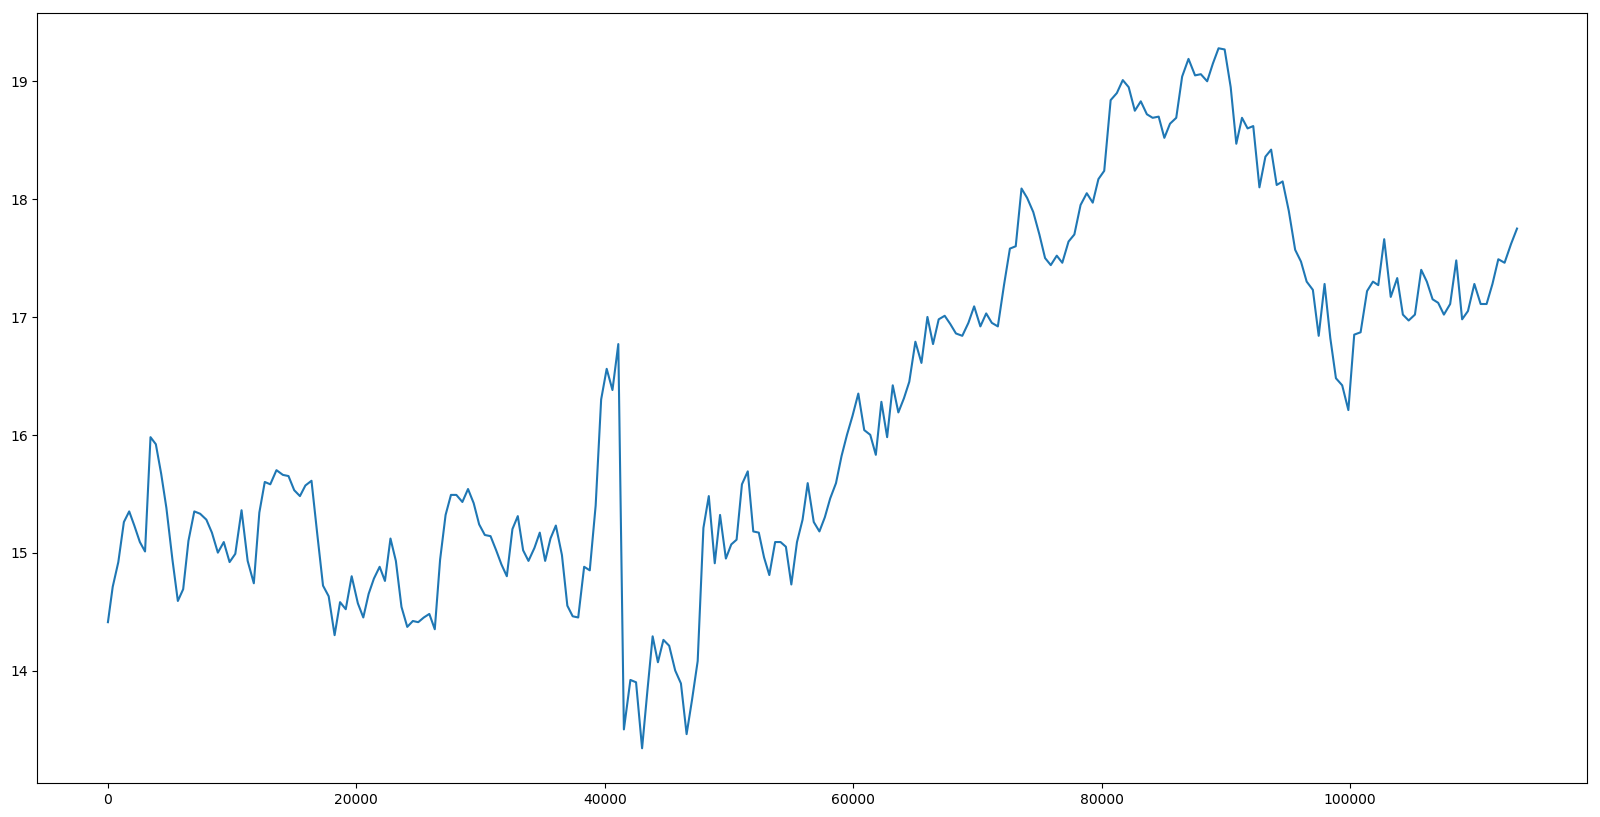

In [7]:
plt.close('all')
plt.rcdefaults()
df_raw_data2 = df_raw_data.drop(columns=rem_names)
plt.figure(figsize=(20,10))
gb_symbol.get_group('ALSC3').plot()
print(gb_symbol.get_group('ALSC3'))
#df_raw_data2.ix[:, ['AMAR3', 'ATOM3','BEES3','BOBR4']].plot(alpha=1, lw=1)
#plt.legend(loc=2,fontsize=6,ncol=8)
#plt.ylim((-0.4,1))
plt.show()
#plt.savefig('logretorn.pdf')

In [8]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
#    if sigma > 2:
#        return random_portfolio(returns)
    return mu, sigma

def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N -1) for t in range(N)]
#    mus = np.linspace(0.1,10**4,N)
#    print(mus)
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks, portfolios

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


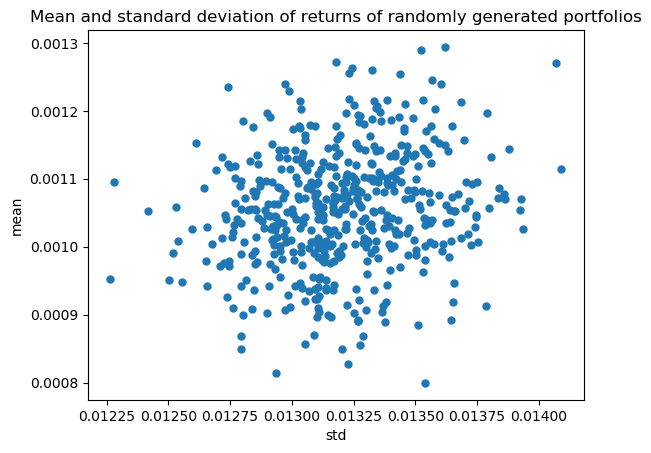

In [9]:
L_assets = list(df_raw_data2.columns)[:200]
df_raw_data3 = df_raw_data2.ix[:, L_assets ]

n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(df_raw_data3.values.T) 
    for _ in range(n_portfolios)
])
plt.close('all')
plt.rcdefaults()
#plt.plot(risks, returns, 'y-o')
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')
plt.show()

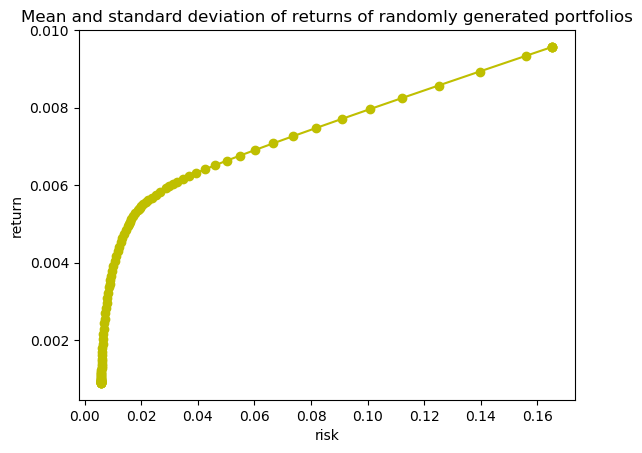

In [10]:
weights, returns, risks, port = optimal_portfolio(df_raw_data3.T)
#plt.plot(df_raw_data2.std(axis=1), 'o', markersize=5)
#plt.plot(stds, means, 'o')
plt.plot(risks, returns, 'y-o')
plt.xlabel('risk')
plt.ylabel('return')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')
plt.show()

In [11]:
#for i in range(len(list(df_raw_data3.columns))):
#   print(list(df_raw_data3.columns)[i],weights[i])

In [12]:
weights.max(),list(df_raw_data3.columns)[3]

(0.9999999053570414, 'ALSC3')

In [13]:
#mean of log returns by asset
rm = np.mean(df_raw_data3.T,axis=1)
Rm_t = []
for j in range(len(port)-1,-1,-1):
    Rm_t.append((rm@np.asmatrix(port[j])).tolist()[0][0])
#np.sqrt(np.asmatrix(port[-1]).T@np.cov(df_raw_data3.T)@np.asmatrix(port[-1]))
AA = []
for i in range(len(port)):
    AA.append(np.asmatrix(port[i]).T.tolist()[0])
BB = np.array(np.asmatrix(AA).T)
#len(BB)
#print(len(port))
#Rm_t[0]
#rm.T@BB[-1]
#np.mean(df_raw_data3.T,axis=1)

In [14]:
N=100
len(np.linspace(0.1,10**4,100))
print(BB.shape)
Rm_year = [(np.exp(x))**246 for x in Rm_t]
type(ind)

(138, 100)


NameError: name 'ind' is not defined

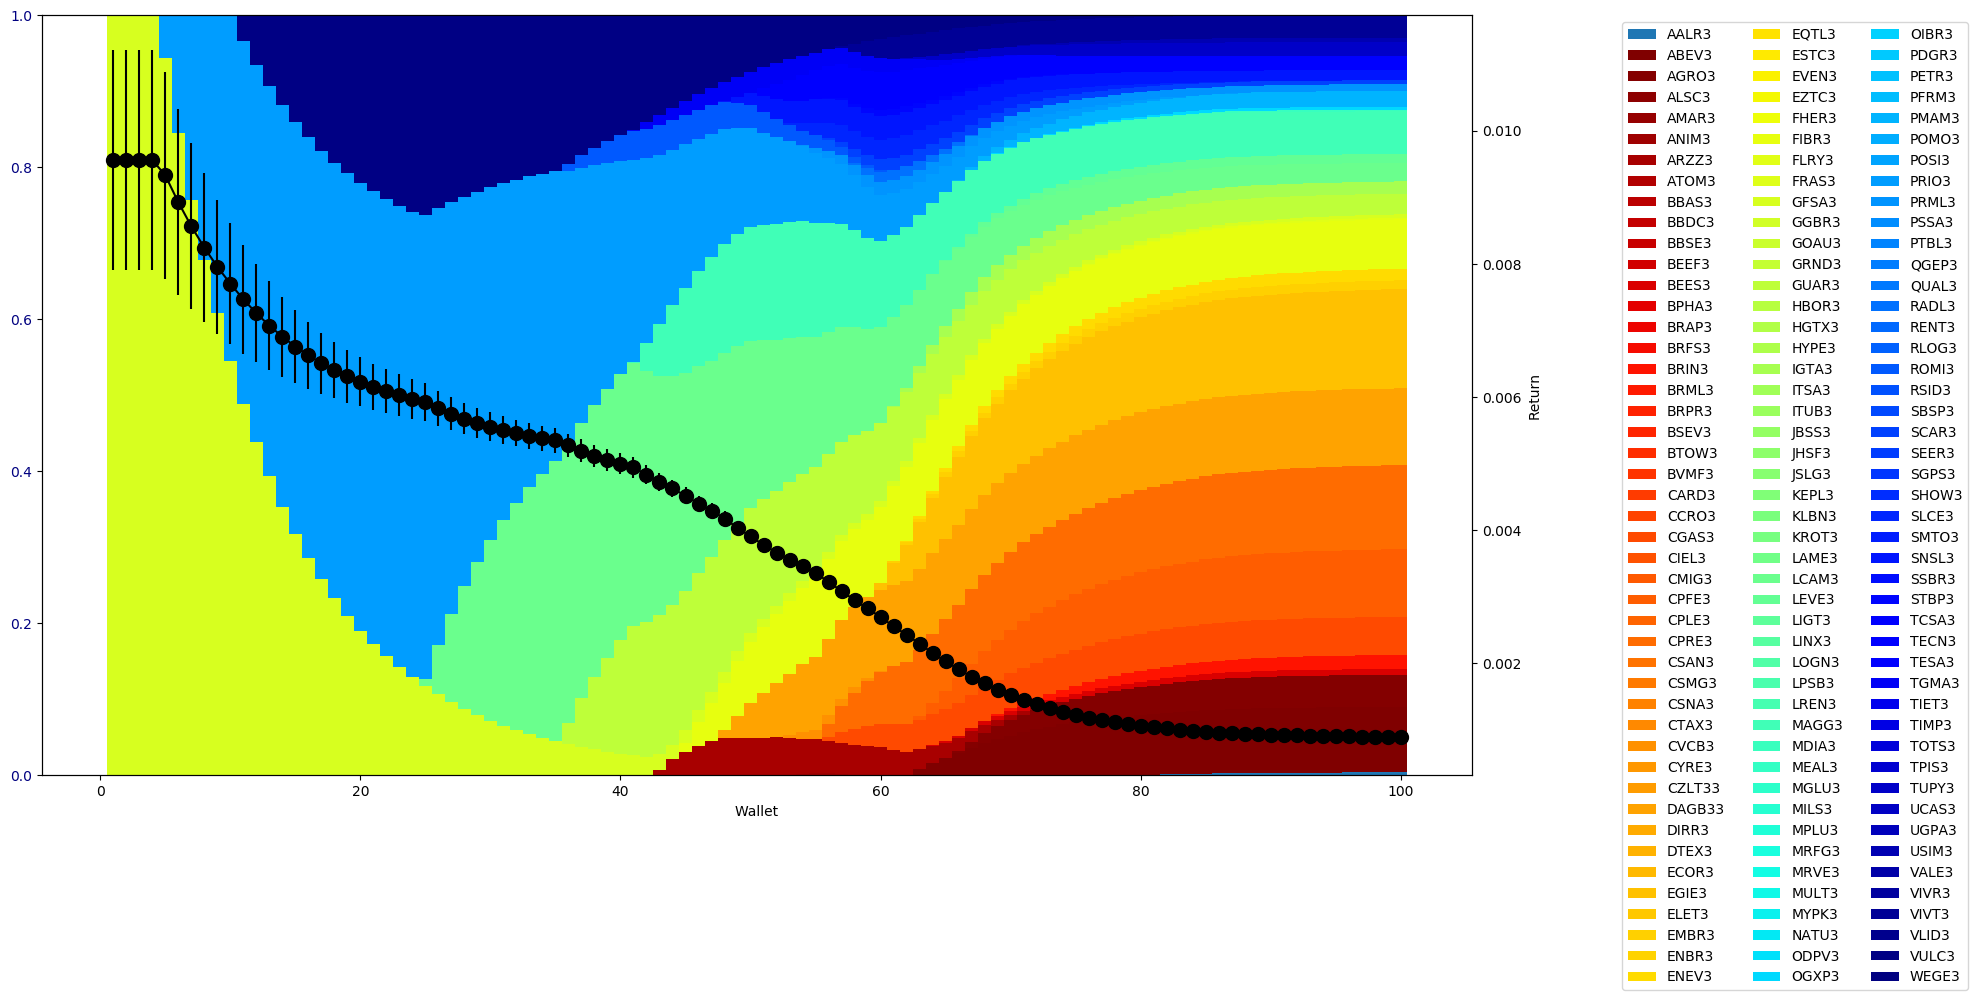

In [15]:
plt.close('all')
number = BB.shape[0]-1
cmap = plt.get_cmap('jet_r')
colors = [cmap(i) for i in np.linspace(0,1, number)]
ind = np.linspace(1,BB.shape[1],BB.shape[1])
fig, ax1 = plt.subplots(figsize=(20,10))
#ax1 = plt.subplots(figsize=(20,10))
ax1.bar(ind,BB[0],width=1)
BB_b = np.zeros(BB.shape[1])
for i,color in enumerate(colors, start=1):
    BB_b = BB_b + BB[i-1]
    ax1.bar(ind,BB[i],bottom=BB_b, color=color,width=1)
ax1.legend(df_raw_data3.columns,bbox_to_anchor=(1.1, 1),ncol=3)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
ax2.errorbar(ind, Rm_t[::-1], [x/100 for x in risks],marker='o',ms=10,color='k')
ax2.set_ylabel('Return')
ax1.set_xlabel('Wallet')
fig.tight_layout()
#plt.savefig('return_year_combination.pdf')
plt.show()

In [ ]:
print(type(ind[0]),type(Rm_year[0]),type(risks[0]))
#for i in range(len(risks)):
#    print(ind[i],returns[i],risks[i]/10)
plt.close('all')
plt.errorbar(ind,Rm_year,[ x for x in risks ],marker='o',ms=10,color='k')
plt.show()

In [ ]:
ax2 = ax1.twinx()
ax2.errorbar(ind, [np.exp(x)**246 for x in returns], risks,ms=10,color='k')
ax2.set_ylabel('Return')
ax1.set_xlabel('Wallet')
fig.tight_layout()
#plt.savefig('return_combination.pdf')
plt.show()

In [153]:
Distances = np.sqrt(2*(1-np.asmatrix(np.corrcoef(df_raw_data3.T))))
import networkx as nx
import pygraphviz
#G = nx.from_numpy_matrix(Distances)
N_labels = len(df_raw_data3.columns)
G2 = nx.Graph()
for i in range(N_labels):
    for j in range(N_labels):
        if i==j:
            continue
        #u=G.add_node(list(df_raw_data3.columns)[i])
        #u = list(df_raw_data3.columns)[i]
        #v=G.add_node(list(df_raw_data3.columns)[j])
        #v = list(df_raw_data3.columns)[j]
        G2.add_edge(list(df_raw_data3.columns)[i],list(df_raw_data3.columns)[j], weight=float(Distances[i,j]))
        print(list(df_raw_data3.columns)[i],list(df_raw_data3.columns)[j],float(Distances[i,j]),i,j)


#nx.set_node_attributes(G, 'label', dict(zip(range(len(df_raw_data3.T)), df_raw_data3.T.index.values)))

AALR3 ABEV3 1.2013988206798907 0 1
AALR3 AGRO3 1.2695361514830552 0 2
AALR3 ALSC3 1.1981647071135226 0 3
AALR3 AMAR3 1.2858801448146442 0 4
AALR3 ANIM3 1.2509150474443589 0 5
AALR3 ARZZ3 1.3577641933055868 0 6
AALR3 ATOM3 1.2077964306008602 0 7
AALR3 BBAS3 1.156578202862255 0 8
AALR3 BBDC3 1.276541287410984 0 9
AALR3 BBSE3 1.1768038695987368 0 10
AALR3 BEEF3 1.1443402773344704 0 11
AALR3 BEES3 1.2521531245538258 0 12
AALR3 BPHA3 1.3186362109809129 0 13
AALR3 BRAP3 1.2657579691079592 0 14
AALR3 BRFS3 1.1610028838080957 0 15
AALR3 BRIN3 1.4049082347937842 0 16
AALR3 BRML3 1.2428287842849197 0 17
AALR3 BRPR3 1.1868509962822753 0 18
AALR3 BSEV3 1.3099685930724028 0 19
AALR3 BTOW3 1.2434617484487296 0 20
AALR3 BVMF3 1.1652022605510468 0 21
AALR3 CARD3 1.3354345533493277 0 22
AALR3 CCRO3 1.1811082341870587 0 23
AALR3 CGAS3 1.3123639764603983 0 24
AALR3 CIEL3 1.25083094937382 0 25
AALR3 CMIG3 1.3077334336526347 0 26
AALR3 CPFE3 1.32364857203531 0 27
AALR3 CPLE3 1.3018676840832917 0 28
AALR3 C

AGRO3 VULC3 1.3282690355110196 2 136
AGRO3 WEGE3 1.2175649222359277 2 137
ALSC3 AALR3 1.1981647071135226 3 0
ALSC3 ABEV3 1.0561192222652438 3 1
ALSC3 AGRO3 1.0072976233183903 3 2
ALSC3 AMAR3 1.1397877306003021 3 4
ALSC3 ANIM3 1.0825275477829803 3 5
ALSC3 ARZZ3 1.2362596843774476 3 6
ALSC3 ATOM3 1.2708014383585295 3 7
ALSC3 BBAS3 0.775668271246417 3 8
ALSC3 BBDC3 0.9576838507762222 3 9
ALSC3 BBSE3 0.9424006603585174 3 10
ALSC3 BEEF3 1.0415819482982585 3 11
ALSC3 BEES3 1.2351393049395027 3 12
ALSC3 BPHA3 1.181713570853166 3 13
ALSC3 BRAP3 1.1915754287373235 3 14
ALSC3 BRFS3 1.1104779206551778 3 15
ALSC3 BRIN3 1.391989053276502 3 16
ALSC3 BRML3 0.8737671264796573 3 17
ALSC3 BRPR3 0.9608572859837347 3 18
ALSC3 BSEV3 1.2044471258239347 3 19
ALSC3 BTOW3 1.1655490409863825 3 20
ALSC3 BVMF3 0.8699309750245654 3 21
ALSC3 CARD3 1.140950329326475 3 22
ALSC3 CCRO3 0.932438094350568 3 23
ALSC3 CGAS3 1.2637999251146583 3 24
ALSC3 CIEL3 1.1101264422986046 3 25
ALSC3 CMIG3 1.162897316404697 3 26
ALSC3

AMAR3 PRIO3 1.3558072842134756 4 99
AMAR3 PRML3 1.3549111135238425 4 100
AMAR3 PSSA3 1.1979507488815166 4 101
AMAR3 PTBL3 1.2393670770448697 4 102
AMAR3 QGEP3 1.2976343984885956 4 103
AMAR3 QUAL3 1.205933281714297 4 104
AMAR3 RADL3 1.2455231546243173 4 105
AMAR3 RENT3 1.350614194587819 4 106
AMAR3 RLOG3 1.2000026870694238 4 107
AMAR3 ROMI3 1.3313182871049296 4 108
AMAR3 RSID3 1.283181184659369 4 109
AMAR3 SBSP3 1.2185055705361556 4 110
AMAR3 SCAR3 1.2633037015269148 4 111
AMAR3 SEER3 1.2137880592493313 4 112
AMAR3 SGPS3 1.2401134569750802 4 113
AMAR3 SHOW3 1.1829991789879066 4 114
AMAR3 SLCE3 1.1787644751529451 4 115
AMAR3 SMTO3 1.2649280635462328 4 116
AMAR3 SNSL3 1.2631092638662655 4 117
AMAR3 SSBR3 1.1970253117720928 4 118
AMAR3 STBP3 1.1733684054295728 4 119
AMAR3 TCSA3 1.257707331015816 4 120
AMAR3 TECN3 1.1656511610539007 4 121
AMAR3 TESA3 1.3797314913051186 4 122
AMAR3 TGMA3 1.2084075795051588 4 123
AMAR3 TIET3 1.2950659750010056 4 124
AMAR3 TIMP3 1.1940871908330404 4 125
AMAR3 

ATOM3 GOAU3 1.2790223393245261 7 56
ATOM3 GRND3 1.2402708010911672 7 57
ATOM3 GUAR3 1.4060909267159372 7 58
ATOM3 HBOR3 1.2503408690671094 7 59
ATOM3 HGTX3 1.3075335885109443 7 60
ATOM3 HYPE3 1.2679972674234785 7 61
ATOM3 IGTA3 1.320933661248195 7 62
ATOM3 ITSA3 1.2103255966490551 7 63
ATOM3 ITUB3 1.2187818873237573 7 64
ATOM3 JBSS3 1.2873811563840905 7 65
ATOM3 JHSF3 1.218325524791332 7 66
ATOM3 JSLG3 1.3068466256943765 7 67
ATOM3 KEPL3 1.2473098506026987 7 68
ATOM3 KLBN3 1.339626569987542 7 69
ATOM3 KROT3 1.2950100452932354 7 70
ATOM3 LAME3 1.2632814990011436 7 71
ATOM3 LCAM3 1.3752590657841233 7 72
ATOM3 LEVE3 1.3201181104672826 7 73
ATOM3 LIGT3 1.3318515418429322 7 74
ATOM3 LINX3 1.237203046177058 7 75
ATOM3 LOGN3 1.2270229075374295 7 76
ATOM3 LPSB3 1.304159621151852 7 77
ATOM3 LREN3 1.2302402170335953 7 78
ATOM3 MAGG3 1.3877468718128099 7 79
ATOM3 MDIA3 1.382147297107235 7 80
ATOM3 MEAL3 1.2454236578444071 7 81
ATOM3 MGLU3 1.3772284683938776 7 82
ATOM3 MILS3 1.2816541284629233 7 8

BBSE3 JHSF3 1.2209874134811531 10 66
BBSE3 JSLG3 1.212818126875227 10 67
BBSE3 KEPL3 1.1510461910458463 10 68
BBSE3 KLBN3 1.2198252235641964 10 69
BBSE3 KROT3 1.0661743966826598 10 70
BBSE3 LAME3 1.0132341239900002 10 71
BBSE3 LCAM3 1.2096846313638576 10 72
BBSE3 LEVE3 1.2410478296983993 10 73
BBSE3 LIGT3 1.0923735294917833 10 74
BBSE3 LINX3 1.0720412382818287 10 75
BBSE3 LOGN3 1.1353899456836727 10 76
BBSE3 LPSB3 1.3205922594582002 10 77
BBSE3 LREN3 0.9092651969870527 10 78
BBSE3 MAGG3 1.2388529979559066 10 79
BBSE3 MDIA3 1.357522938286132 10 80
BBSE3 MEAL3 1.0862009548657345 10 81
BBSE3 MGLU3 1.3676465012509704 10 82
BBSE3 MILS3 1.0843519805898625 10 83
BBSE3 MPLU3 1.0602536509737934 10 84
BBSE3 MRFG3 1.0057095158356164 10 85
BBSE3 MRVE3 0.9733082424427729 10 86
BBSE3 MULT3 0.8967401578261527 10 87
BBSE3 MYPK3 1.0472686098921107 10 88
BBSE3 NATU3 1.0416402266307057 10 89
BBSE3 ODPV3 1.0834840423511183 10 90
BBSE3 OGXP3 1.2930640392462769 10 91
BBSE3 OIBR3 1.1697432482771624 10 92
BBS

BEES3 ECOR3 1.2418952412938435 12 40
BEES3 EGIE3 1.28574176986771 12 41
BEES3 ELET3 1.2161543675566373 12 42
BEES3 EMBR3 1.4153316074048388 12 43
BEES3 ENBR3 1.246550632008115 12 44
BEES3 ENEV3 1.227901867926568 12 45
BEES3 EQTL3 1.2038499414781205 12 46
BEES3 ESTC3 1.3653504412811959 12 47
BEES3 EVEN3 1.3086971723669132 12 48
BEES3 EZTC3 1.262290127147313 12 49
BEES3 FHER3 1.144998025284042 12 50
BEES3 FIBR3 1.4802124821353233 12 51
BEES3 FLRY3 1.3715769808136486 12 52
BEES3 FRAS3 1.2196208492810428 12 53
BEES3 GFSA3 1.414552916873361 12 54
BEES3 GGBR3 1.2450582002929103 12 55
BEES3 GOAU3 1.323070959107188 12 56
BEES3 GRND3 1.1506652088281673 12 57
BEES3 GUAR3 1.3685333383731566 12 58
BEES3 HBOR3 1.2234823112550541 12 59
BEES3 HGTX3 1.270968832311461 12 60
BEES3 HYPE3 1.174501254825219 12 61
BEES3 IGTA3 1.2684393258297757 12 62
BEES3 ITSA3 1.2101235303516844 12 63
BEES3 ITUB3 1.1884321058501637 12 64
BEES3 JBSS3 1.2652928792837097 12 65
BEES3 JHSF3 1.2440042260828992 12 66
BEES3 JSLG3

BRAP3 ABEV3 1.263348320050246 14 1
BRAP3 AGRO3 1.2590626922676622 14 2
BRAP3 ALSC3 1.1915754287373235 14 3
BRAP3 AMAR3 1.2942468253232768 14 4
BRAP3 ANIM3 1.2027988479189025 14 5
BRAP3 ARZZ3 1.32592404565997 14 6
BRAP3 ATOM3 1.262031499058068 14 7
BRAP3 BBAS3 1.122201308207758 14 8
BRAP3 BBDC3 1.2275647383083463 14 9
BRAP3 BBSE3 1.2734353078655858 14 10
BRAP3 BEEF3 1.1936604091861178 14 11
BRAP3 BEES3 1.338606599467617 14 12
BRAP3 BPHA3 1.2459611494081226 14 13
BRAP3 BRFS3 1.2386200009008683 14 15
BRAP3 BRIN3 1.3564738389187208 14 16
BRAP3 BRML3 1.1844866590910428 14 17
BRAP3 BRPR3 1.2003458016778912 14 18
BRAP3 BSEV3 1.2720888240896362 14 19
BRAP3 BTOW3 1.2674888008164809 14 20
BRAP3 BVMF3 1.1308268872987093 14 21
BRAP3 CARD3 1.232234174470126 14 22
BRAP3 CCRO3 1.1797696451605042 14 23
BRAP3 CGAS3 1.332532786613252 14 24
BRAP3 CIEL3 1.1944354597816471 14 25
BRAP3 CMIG3 1.2533257951542898 14 26
BRAP3 CPFE3 1.3789903529586494 14 27
BRAP3 CPLE3 1.285080090795154 14 28
BRAP3 CPRE3 1.36800

BRIN3 SBSP3 1.414622081983845 16 110
BRIN3 SCAR3 1.3482132290118993 16 111
BRIN3 SEER3 1.309479070770843 16 112
BRIN3 SGPS3 1.4150250172430727 16 113
BRIN3 SHOW3 1.3949161819612155 16 114
BRIN3 SLCE3 1.3950200167330142 16 115
BRIN3 SMTO3 1.3760176890358957 16 116
BRIN3 SNSL3 1.3620801662578954 16 117
BRIN3 SSBR3 1.3684241638261905 16 118
BRIN3 STBP3 1.3856525675172766 16 119
BRIN3 TCSA3 1.3624749364226367 16 120
BRIN3 TECN3 1.4178482134390509 16 121
BRIN3 TESA3 1.3628768248739909 16 122
BRIN3 TGMA3 1.4378096516966477 16 123
BRIN3 TIET3 1.396671849179019 16 124
BRIN3 TIMP3 1.3306441000422815 16 125
BRIN3 TOTS3 1.3694381661669668 16 126
BRIN3 TPIS3 1.3522122733110384 16 127
BRIN3 TUPY3 1.4702218495405157 16 128
BRIN3 UCAS3 1.3898513758483428 16 129
BRIN3 UGPA3 1.4464250171350919 16 130
BRIN3 USIM3 1.4260031711796581 16 131
BRIN3 VALE3 1.3572980565325072 16 132
BRIN3 VIVR3 1.345156278573435 16 133
BRIN3 VIVT3 1.3627350724992962 16 134
BRIN3 VLID3 1.3111089852225741 16 135
BRIN3 VULC3 1.32

BRPR3 SNSL3 1.2208297583781471 18 117
BRPR3 SSBR3 1.0986085343170309 18 118
BRPR3 STBP3 1.254455105065126 18 119
BRPR3 TCSA3 1.0759253459931386 18 120
BRPR3 TECN3 0.9785434987766628 18 121
BRPR3 TESA3 1.349920340612571 18 122
BRPR3 TGMA3 1.1561623844940965 18 123
BRPR3 TIET3 1.2341994471427031 18 124
BRPR3 TIMP3 1.1499095078911272 18 125
BRPR3 TOTS3 1.1983027141456615 18 126
BRPR3 TPIS3 1.1060782899734884 18 127
BRPR3 TUPY3 1.128001709001317 18 128
BRPR3 UCAS3 1.3055655762564633 18 129
BRPR3 UGPA3 1.2372487331753395 18 130
BRPR3 USIM3 1.2426996893879603 18 131
BRPR3 VALE3 1.2345076705348381 18 132
BRPR3 VIVR3 1.3102535566843487 18 133
BRPR3 VIVT3 1.2736651608795146 18 134
BRPR3 VLID3 1.1174436718984844 18 135
BRPR3 VULC3 1.3546527797718266 18 136
BRPR3 WEGE3 1.138106785336825 18 137
BSEV3 AALR3 1.3099685930724028 19 0
BSEV3 ABEV3 1.2719806141561512 19 1
BSEV3 AGRO3 1.1601401681304433 19 2
BSEV3 ALSC3 1.2044471258239347 19 3
BSEV3 AMAR3 1.2615692853681229 19 4
BSEV3 ANIM3 1.217595902001

BVMF3 SMTO3 1.0053550909365436 21 116
BVMF3 SNSL3 1.216373750561215 21 117
BVMF3 SSBR3 1.065434832008628 21 118
BVMF3 STBP3 1.2935359049972275 21 119
BVMF3 TCSA3 1.0028886555514436 21 120
BVMF3 TECN3 0.9562987822180464 21 121
BVMF3 TESA3 1.3730418217704017 21 122
BVMF3 TGMA3 1.0727319552851449 21 123
BVMF3 TIET3 1.2069120520097505 21 124
BVMF3 TIMP3 0.9316292776182941 21 125
BVMF3 TOTS3 1.072135303158471 21 126
BVMF3 TPIS3 1.095336234361861 21 127
BVMF3 TUPY3 1.1912467978649504 21 128
BVMF3 UCAS3 1.1990824598159047 21 129
BVMF3 UGPA3 1.0013884767811831 21 130
BVMF3 USIM3 1.214139205359954 21 131
BVMF3 VALE3 1.1067307664501393 21 132
BVMF3 VIVR3 1.2555021714137757 21 133
BVMF3 VIVT3 1.277683293004535 21 134
BVMF3 VLID3 1.0763595982412608 21 135
BVMF3 VULC3 1.3454786616006655 21 136
BVMF3 WEGE3 0.9920239830671902 21 137
CARD3 AALR3 1.3354345533493277 22 0
CARD3 ABEV3 1.2298087000875537 22 1
CARD3 AGRO3 1.2582517568769016 22 2
CARD3 ALSC3 1.140950329326475 22 3
CARD3 AMAR3 1.2471059146729

CIEL3 DAGB33 1.473600487614768 25 37
CIEL3 DIRR3 1.1058478262348734 25 38
CIEL3 DTEX3 1.2815826390749399 25 39
CIEL3 ECOR3 1.0884091817779098 25 40
CIEL3 EGIE3 1.1756536639601807 25 41
CIEL3 ELET3 1.271768322043603 25 42
CIEL3 EMBR3 1.2711164200152771 25 43
CIEL3 ENBR3 1.1126107234856843 25 44
CIEL3 ENEV3 1.2802930771364935 25 45
CIEL3 EQTL3 1.0821365030584564 25 46
CIEL3 ESTC3 1.2446214561569122 25 47
CIEL3 EVEN3 1.2116057763672514 25 48
CIEL3 EZTC3 1.157578852361328 25 49
CIEL3 FHER3 1.145616542597813 25 50
CIEL3 FIBR3 1.433997554733154 25 51
CIEL3 FLRY3 1.3183871174785218 25 52
CIEL3 FRAS3 1.2354349953404105 25 53
CIEL3 GFSA3 1.3792467014464351 25 54
CIEL3 GGBR3 1.1403374599937943 25 55
CIEL3 GOAU3 1.2043161615996987 25 56
CIEL3 GRND3 1.1191596155807797 25 57
CIEL3 GUAR3 1.3901350654875457 25 58
CIEL3 HBOR3 1.1775670936639404 25 59
CIEL3 HGTX3 1.1820589242966886 25 60
CIEL3 HYPE3 0.9972308499652393 25 61
CIEL3 IGTA3 1.2058500153139968 25 62
CIEL3 ITSA3 1.210106723299615 25 63
CIEL3 

CPLE3 HBOR3 1.191109003400467 28 59
CPLE3 HGTX3 1.2167214427733433 28 60
CPLE3 HYPE3 1.226601985973803 28 61
CPLE3 IGTA3 1.1888974853941336 28 62
CPLE3 ITSA3 1.073234219980536 28 63
CPLE3 ITUB3 1.068052090676892 28 64
CPLE3 JBSS3 1.2215623380161935 28 65
CPLE3 JHSF3 1.2081009393122142 28 66
CPLE3 JSLG3 1.22972508354554 28 67
CPLE3 KEPL3 1.2537692484632756 28 68
CPLE3 KLBN3 1.303176838929097 28 69
CPLE3 KROT3 1.14204524081276 28 70
CPLE3 LAME3 1.1187013902006546 28 71
CPLE3 LCAM3 1.3175846930139852 28 72
CPLE3 LEVE3 1.3007343466183545 28 73
CPLE3 LIGT3 1.1734421306387597 28 74
CPLE3 LINX3 1.2411804971423714 28 75
CPLE3 LOGN3 1.2207405707204635 28 76
CPLE3 LPSB3 1.3315147269302094 28 77
CPLE3 LREN3 1.1088421874030086 28 78
CPLE3 MAGG3 1.3377493614336835 28 79
CPLE3 MDIA3 1.3717604732601092 28 80
CPLE3 MEAL3 1.2129657114254861 28 81
CPLE3 MGLU3 1.4142756889555541 28 82
CPLE3 MILS3 1.1759961896746376 28 83
CPLE3 MPLU3 1.1463865619250568 28 84
CPLE3 MRFG3 1.2105835651521488 28 85
CPLE3 MRVE

CSAN3 DIRR3 0.9858241424158016 30 38
CSAN3 DTEX3 1.0788838432951304 30 39
CSAN3 ECOR3 1.0208326638063407 30 40
CSAN3 EGIE3 1.126051557385895 30 41
CSAN3 ELET3 1.2016512825976715 30 42
CSAN3 EMBR3 1.2330431383364695 30 43
CSAN3 ENBR3 1.0570896807900194 30 44
CSAN3 ENEV3 1.2796186302179051 30 45
CSAN3 EQTL3 1.0604906384207535 30 46
CSAN3 ESTC3 1.111807516070129 30 47
CSAN3 EVEN3 1.1644678329828468 30 48
CSAN3 EZTC3 1.0816833485976944 30 49
CSAN3 FHER3 1.065217072323293 30 50
CSAN3 FIBR3 1.4490617242868304 30 51
CSAN3 FLRY3 1.342099715327399 30 52
CSAN3 FRAS3 1.196814153591623 30 53
CSAN3 GFSA3 1.2967918042618483 30 54
CSAN3 GGBR3 1.0575277438435347 30 55
CSAN3 GOAU3 1.0540605721596819 30 56
CSAN3 GRND3 1.046143727165152 30 57
CSAN3 GUAR3 1.3412864222952585 30 58
CSAN3 HBOR3 1.1480288337510058 30 59
CSAN3 HGTX3 1.1069528128548278 30 60
CSAN3 HYPE3 0.9944746707794534 30 61
CSAN3 IGTA3 1.1085379582858519 30 62
CSAN3 ITSA3 1.044290659955933 30 63
CSAN3 ITUB3 1.0327459016256342 30 64
CSAN3 JB

CTAX3 BRFS3 1.209623221418297 33 15
CTAX3 BRIN3 1.395468656436249 33 16
CTAX3 BRML3 1.0764588067868668 33 17
CTAX3 BRPR3 1.0775120223384491 33 18
CTAX3 BSEV3 1.2295483764865474 33 19
CTAX3 BTOW3 1.1967517570480466 33 20
CTAX3 BVMF3 1.0065075352925814 33 21
CTAX3 CARD3 1.1936682080491403 33 22
CTAX3 CCRO3 1.1077682043201351 33 23
CTAX3 CGAS3 1.326707189352781 33 24
CTAX3 CIEL3 1.1516046668138236 33 25
CTAX3 CMIG3 1.2709786466820867 33 26
CTAX3 CPFE3 1.4215935245017064 33 27
CTAX3 CPLE3 1.1630148613275868 33 28
CTAX3 CPRE3 1.3317055148650245 33 29
CTAX3 CSAN3 1.1571504214214754 33 30
CTAX3 CSMG3 1.179834997733403 33 31
CTAX3 CSNA3 1.1701784891570655 33 32
CTAX3 CVCB3 1.1845595644128812 33 34
CTAX3 CYRE3 1.0310294589253397 33 35
CTAX3 CZLT33 1.3205635240714746 33 36
CTAX3 DAGB33 1.3752966860838483 33 37
CTAX3 DIRR3 1.04535886007794 33 38
CTAX3 DTEX3 1.1872940739830098 33 39
CTAX3 ECOR3 1.1068860219404364 33 40
CTAX3 EGIE3 1.2082795748439874 33 41
CTAX3 ELET3 1.22311117069642 33 42
CTAX3 E

CVCB3 VALE3 1.2205092368416826 34 132
CVCB3 VIVR3 1.3499933857526016 34 133
CVCB3 VIVT3 1.3077913895006867 34 134
CVCB3 VLID3 1.1144650613527314 34 135
CVCB3 VULC3 1.3719784613676258 34 136
CVCB3 WEGE3 1.133437653955882 34 137
CYRE3 AALR3 1.2015885742907857 35 0
CYRE3 ABEV3 1.0874260630177943 35 1
CYRE3 AGRO3 1.1184238898941914 35 2
CYRE3 ALSC3 0.846962386404595 35 3
CYRE3 AMAR3 1.224205586461248 35 4
CYRE3 ANIM3 1.1085905570829022 35 5
CYRE3 ARZZ3 1.2683626064574087 35 6
CYRE3 ATOM3 1.2259154422338194 35 7
CYRE3 BBAS3 0.7668108862884712 35 8
CYRE3 BBDC3 0.9517735508594519 35 9
CYRE3 BBSE3 0.898666562099669 35 10
CYRE3 BEEF3 1.0609776806280689 35 11
CYRE3 BEES3 1.1965077305421743 35 12
CYRE3 BPHA3 1.17029175349135 35 13
CYRE3 BRAP3 1.2073691371252435 35 14
CYRE3 BRFS3 1.0640574147904929 35 15
CYRE3 BRIN3 1.4429886651073287 35 16
CYRE3 BRML3 0.873294745668846 35 17
CYRE3 BRPR3 0.9457816247013688 35 18
CYRE3 BSEV3 1.143560235496735 35 19
CYRE3 BTOW3 1.1222832211149592 35 20
CYRE3 BVMF3 0

DAGB33 VLID3 1.4894806290566092 37 135
DAGB33 VULC3 1.457690681834393 37 136
DAGB33 WEGE3 1.4892074965653468 37 137
DIRR3 AALR3 1.228569104500728 38 0
DIRR3 ABEV3 1.1250472890748018 38 1
DIRR3 AGRO3 1.1041029994476232 38 2
DIRR3 ALSC3 0.9707366744507852 38 3
DIRR3 AMAR3 1.2184541464616376 38 4
DIRR3 ANIM3 1.149661246635605 38 5
DIRR3 ARZZ3 1.2321519311410758 38 6
DIRR3 ATOM3 1.2632052881552591 38 7
DIRR3 BBAS3 0.8492917173381264 38 8
DIRR3 BBDC3 0.9859909461235191 38 9
DIRR3 BBSE3 1.0283336106046925 38 10
DIRR3 BEEF3 1.084133580595757 38 11
DIRR3 BEES3 1.1752326359757275 38 12
DIRR3 BPHA3 1.2093036785192044 38 13
DIRR3 BRAP3 1.2169456466766988 38 14
DIRR3 BRFS3 1.1453106132492366 38 15
DIRR3 BRIN3 1.4093334142755045 38 16
DIRR3 BRML3 1.0260811807245624 38 17
DIRR3 BRPR3 1.0678703649342307 38 18
DIRR3 BSEV3 1.1577426944592735 38 19
DIRR3 BTOW3 1.2076158195552038 38 20
DIRR3 BVMF3 0.9192633876536497 38 21
DIRR3 CARD3 1.1895409464768854 38 22
DIRR3 CCRO3 0.9957585084455769 38 23
DIRR3 CGA

DTEX3 ODPV3 1.1597984775595938 39 90
DTEX3 OGXP3 1.3799990153095947 39 91
DTEX3 OIBR3 1.2072601719108498 39 92
DTEX3 PDGR3 1.2896535367520916 39 93
DTEX3 PETR3 1.1145934945419953 39 94
DTEX3 PFRM3 1.2343258465081315 39 95
DTEX3 PMAM3 1.2780560108982228 39 96
DTEX3 POMO3 1.1836453947535197 39 97
DTEX3 POSI3 1.2054559655008998 39 98
DTEX3 PRIO3 1.2167847949303106 39 99
DTEX3 PRML3 1.3486434857666392 39 100
DTEX3 PSSA3 1.2406730848357401 39 101
DTEX3 PTBL3 1.089338130186814 39 102
DTEX3 QGEP3 1.2309992866513049 39 103
DTEX3 QUAL3 1.1801960545743533 39 104
DTEX3 RADL3 1.2182615150441922 39 105
DTEX3 RENT3 1.3516376568388775 39 106
DTEX3 RLOG3 1.11893215193221 39 107
DTEX3 ROMI3 1.1793688393284105 39 108
DTEX3 RSID3 1.2594048333823145 39 109
DTEX3 SBSP3 1.1356614637843399 39 110
DTEX3 SCAR3 1.205449361045468 39 111
DTEX3 SEER3 1.1334895652250967 39 112
DTEX3 SGPS3 1.2789719192302982 39 113
DTEX3 SHOW3 1.17635865467479 39 114
DTEX3 SLCE3 1.1471049253359769 39 115
DTEX3 SMTO3 1.14205255520675

EGIE3 EZTC3 1.136636164076668 41 49
EGIE3 FHER3 1.2167417650877383 41 50
EGIE3 FIBR3 1.4705268934596467 41 51
EGIE3 FLRY3 1.350171208006909 41 52
EGIE3 FRAS3 1.2696308277656165 41 53
EGIE3 GFSA3 1.381602995290402 41 54
EGIE3 GGBR3 1.1827812312452772 41 55
EGIE3 GOAU3 1.1560857382600687 41 56
EGIE3 GRND3 1.1922894188125255 41 57
EGIE3 GUAR3 1.321890584035296 41 58
EGIE3 HBOR3 1.181056107388532 41 59
EGIE3 HGTX3 1.2044104526831725 41 60
EGIE3 HYPE3 1.1369421857559971 41 61
EGIE3 IGTA3 1.2377841015106013 41 62
EGIE3 ITSA3 1.1032256355694157 41 63
EGIE3 ITUB3 1.1150475108467877 41 64
EGIE3 JBSS3 1.249424789934187 41 65
EGIE3 JHSF3 1.1978898705201806 41 66
EGIE3 JSLG3 1.2815684154898972 41 67
EGIE3 KEPL3 1.2489861112647 41 68
EGIE3 KLBN3 1.25681849497329 41 69
EGIE3 KROT3 1.1586536129155123 41 70
EGIE3 LAME3 1.1583934261043025 41 71
EGIE3 LCAM3 1.2628002464656065 41 72
EGIE3 LEVE3 1.2600454512857777 41 73
EGIE3 LIGT3 1.2245226053964544 41 74
EGIE3 LINX3 1.329233583349742 41 75
EGIE3 LOGN3 1

ENBR3 MULT3 1.0065006676444594 44 87
ENBR3 MYPK3 1.1320525169068256 44 88
ENBR3 NATU3 1.122249518690853 44 89
ENBR3 ODPV3 1.163159905714433 44 90
ENBR3 OGXP3 1.3187015833273998 44 91
ENBR3 OIBR3 1.2018307249718496 44 92
ENBR3 PDGR3 1.225819164925658 44 93
ENBR3 PETR3 1.149529649801191 44 94
ENBR3 PFRM3 1.1739230812626562 44 95
ENBR3 PMAM3 1.274429356457466 44 96
ENBR3 POMO3 1.1397951314498835 44 97
ENBR3 POSI3 1.2281760077734938 44 98
ENBR3 PRIO3 1.2479451200369274 44 99
ENBR3 PRML3 1.3029614273775056 44 100
ENBR3 PSSA3 1.1915554781913484 44 101
ENBR3 PTBL3 1.082957750287391 44 102
ENBR3 QGEP3 1.2750330671381307 44 103
ENBR3 QUAL3 1.1221356455956704 44 104
ENBR3 RADL3 1.130813480360319 44 105
ENBR3 RENT3 1.3308804092042639 44 106
ENBR3 RLOG3 1.1336376645865338 44 107
ENBR3 ROMI3 1.327817272072442 44 108
ENBR3 RSID3 1.222318802103818 44 109
ENBR3 SBSP3 1.0638680893085604 44 110
ENBR3 SCAR3 1.3047525991236901 44 111
ENBR3 SEER3 1.174816105578472 44 112
ENBR3 SGPS3 1.215834828284831 44 11

EQTL3 MULT3 1.0015634327571794 46 87
EQTL3 MYPK3 1.1104361339225066 46 88
EQTL3 NATU3 1.1557510003509535 46 89
EQTL3 ODPV3 1.1023947232888835 46 90
EQTL3 OGXP3 1.3722936335406284 46 91
EQTL3 OIBR3 1.1767810356990531 46 92
EQTL3 PDGR3 1.272456175230431 46 93
EQTL3 PETR3 1.0079674572882105 46 94
EQTL3 PFRM3 1.06211537559791 46 95
EQTL3 PMAM3 1.2786821550737864 46 96
EQTL3 POMO3 1.2301034269229334 46 97
EQTL3 POSI3 1.1368040515429854 46 98
EQTL3 PRIO3 1.1920151032586612 46 99
EQTL3 PRML3 1.2233530460354698 46 100
EQTL3 PSSA3 1.0723129473380344 46 101
EQTL3 PTBL3 1.1505657273582832 46 102
EQTL3 QGEP3 1.1623973191966164 46 103
EQTL3 QUAL3 1.1442526794624777 46 104
EQTL3 RADL3 1.1280283516562346 46 105
EQTL3 RENT3 1.3084892764437592 46 106
EQTL3 RLOG3 1.1870809466540653 46 107
EQTL3 ROMI3 1.2755561570156961 46 108
EQTL3 RSID3 1.246733012836169 46 109
EQTL3 SBSP3 1.0401171541276648 46 110
EQTL3 SCAR3 1.2566009903481599 46 111
EQTL3 SEER3 1.1660248580167218 46 112
EQTL3 SGPS3 1.276110733516592

EVEN3 MILS3 1.0817151288501017 48 83
EVEN3 MPLU3 1.10322402654005 48 84
EVEN3 MRFG3 1.1720859003700879 48 85
EVEN3 MRVE3 1.1135640511953844 48 86
EVEN3 MULT3 1.0785235191446798 48 87
EVEN3 MYPK3 1.1099719337552423 48 88
EVEN3 NATU3 1.148221455703743 48 89
EVEN3 ODPV3 1.2115046780819405 48 90
EVEN3 OGXP3 1.39041219599015 48 91
EVEN3 OIBR3 1.2396361023351432 48 92
EVEN3 PDGR3 1.268860654603878 48 93
EVEN3 PETR3 1.1278252074394433 48 94
EVEN3 PFRM3 1.220251414325423 48 95
EVEN3 PMAM3 1.2532083048497615 48 96
EVEN3 POMO3 1.1350969017666193 48 97
EVEN3 POSI3 1.21187877871329 48 98
EVEN3 PRIO3 1.2620998987240268 48 99
EVEN3 PRML3 1.2986349293424495 48 100
EVEN3 PSSA3 1.2328480510554118 48 101
EVEN3 PTBL3 1.1360133923822409 48 102
EVEN3 QGEP3 1.1886530666769892 48 103
EVEN3 QUAL3 1.2238357239166935 48 104
EVEN3 RADL3 1.2210002469438548 48 105
EVEN3 RENT3 1.3495883250258187 48 106
EVEN3 RLOG3 1.152875899107495 48 107
EVEN3 ROMI3 1.2250265500378517 48 108
EVEN3 RSID3 1.1968156882049854 48 109
E

FHER3 EGIE3 1.2167417650877381 50 41
FHER3 ELET3 1.1943841405835764 50 42
FHER3 EMBR3 1.269096256509409 50 43
FHER3 ENBR3 1.1859339146545826 50 44
FHER3 ENEV3 1.2086552495262548 50 45
FHER3 EQTL3 1.0841264615030584 50 46
FHER3 ESTC3 1.183404756428114 50 47
FHER3 EVEN3 1.1482398093031778 50 48
FHER3 EZTC3 1.0824384394305626 50 49
FHER3 FIBR3 1.529800845184174 50 51
FHER3 FLRY3 1.2699225282527133 50 52
FHER3 FRAS3 1.160260640780291 50 53
FHER3 GFSA3 1.318431033078329 50 54
FHER3 GGBR3 1.0645291342729422 50 55
FHER3 GOAU3 1.062749321086055 50 56
FHER3 GRND3 1.0444549978432522 50 57
FHER3 GUAR3 1.3897439111754057 50 58
FHER3 HBOR3 1.0308689407866893 50 59
FHER3 HGTX3 1.1428149580680251 50 60
FHER3 HYPE3 1.0482137313359834 50 61
FHER3 IGTA3 1.1247450193681807 50 62
FHER3 ITSA3 1.0598645674897473 50 63
FHER3 ITUB3 1.010673537461035 50 64
FHER3 JBSS3 1.2639464229576696 50 65
FHER3 JHSF3 1.0259566188883649 50 66
FHER3 JSLG3 1.2226717377435254 50 67
FHER3 KEPL3 1.2047231863391887 50 68
FHER3 KL

FLRY3 EQTL3 1.3571361334446308 52 46
FLRY3 ESTC3 1.3258837752855241 52 47
FLRY3 EVEN3 1.3494461242760878 52 48
FLRY3 EZTC3 1.3171975750477973 52 49
FLRY3 FHER3 1.2699225282527133 52 50
FLRY3 FIBR3 1.4658535125442054 52 51
FLRY3 FRAS3 1.342439935383797 52 53
FLRY3 GFSA3 1.395874600518126 52 54
FLRY3 GGBR3 1.3454298750161722 52 55
FLRY3 GOAU3 1.3826929166150808 52 56
FLRY3 GRND3 1.32125731064518 52 57
FLRY3 GUAR3 1.396824966927011 52 58
FLRY3 HBOR3 1.354483112024662 52 59
FLRY3 HGTX3 1.3293788138517701 52 60
FLRY3 HYPE3 1.3298485040675594 52 61
FLRY3 IGTA3 1.3184955367805438 52 62
FLRY3 ITSA3 1.375724427695557 52 63
FLRY3 ITUB3 1.3104943835341627 52 64
FLRY3 JBSS3 1.3070213826746286 52 65
FLRY3 JHSF3 1.3022114328078016 52 66
FLRY3 JSLG3 1.374410932790213 52 67
FLRY3 KEPL3 1.3672290639007316 52 68
FLRY3 KLBN3 1.4285040703908256 52 69
FLRY3 KROT3 1.2987541460728427 52 70
FLRY3 LAME3 1.329223318968127 52 71
FLRY3 LCAM3 1.3421828702680734 52 72
FLRY3 LEVE3 1.348001583901094 52 73
FLRY3 LIGT3

GGBR3 VALE3 0.9837200168298134 55 132
GGBR3 VIVR3 1.2787044526336897 55 133
GGBR3 VIVT3 1.33854248212021 55 134
GGBR3 VLID3 1.1744149597212923 55 135
GGBR3 VULC3 1.4270939836074616 55 136
GGBR3 WEGE3 1.1714457381091743 55 137
GOAU3 AALR3 1.2441659139964811 56 0
GOAU3 ABEV3 1.2145957465690456 56 1
GOAU3 AGRO3 1.1354457755447254 56 2
GOAU3 ALSC3 1.061190052656011 56 3
GOAU3 AMAR3 1.2407074008538437 56 4
GOAU3 ANIM3 1.1450365179096773 56 5
GOAU3 ARZZ3 1.1749777653025035 56 6
GOAU3 ATOM3 1.2790223393245261 56 7
GOAU3 BBAS3 0.988411096330188 56 8
GOAU3 BBDC3 1.0939105803533256 56 9
GOAU3 BBSE3 1.0781791548713173 56 10
GOAU3 BEEF3 1.2178208583543728 56 11
GOAU3 BEES3 1.323070959107188 56 12
GOAU3 BPHA3 1.2459197004348976 56 13
GOAU3 BRAP3 1.0687315975050944 56 14
GOAU3 BRFS3 1.2132106452413256 56 15
GOAU3 BRIN3 1.3706695440267076 56 16
GOAU3 BRML3 1.1153278897585985 56 17
GOAU3 BRPR3 1.170258138501408 56 18
GOAU3 BSEV3 1.1791646270007872 56 19
GOAU3 BTOW3 1.1361074125780186 56 20
GOAU3 BVMF3

HBOR3 KROT3 1.1634146931167617 59 70
HBOR3 LAME3 1.1430380235570168 59 71
HBOR3 LCAM3 1.332869246772732 59 72
HBOR3 LEVE3 1.21320000096303 59 73
HBOR3 LIGT3 1.22557579730648 59 74
HBOR3 LINX3 1.179234781483468 59 75
HBOR3 LOGN3 1.1520826007577651 59 76
HBOR3 LPSB3 1.2140905537260493 59 77
HBOR3 LREN3 1.0755665921345396 59 78
HBOR3 MAGG3 1.311300239721298 59 79
HBOR3 MDIA3 1.3033499691462653 59 80
HBOR3 MEAL3 1.1793895505795011 59 81
HBOR3 MGLU3 1.383379330494693 59 82
HBOR3 MILS3 1.0552181849431157 59 83
HBOR3 MPLU3 1.107361542820037 59 84
HBOR3 MRFG3 1.203467677867735 59 85
HBOR3 MRVE3 1.0338626243216356 59 86
HBOR3 MULT3 1.0569459334283817 59 87
HBOR3 MYPK3 1.1431434751565133 59 88
HBOR3 NATU3 1.1688566344776752 59 89
HBOR3 ODPV3 1.2649756213706136 59 90
HBOR3 OGXP3 1.3760999982002682 59 91
HBOR3 OIBR3 1.245956058279242 59 92
HBOR3 PDGR3 1.1242756774222682 59 93
HBOR3 PETR3 1.0663547542910592 59 94
HBOR3 PFRM3 1.206789822102659 59 95
HBOR3 PMAM3 1.2834606739162004 59 96
HBOR3 POMO3 1

HYPE3 CSAN3 0.9944746707794534 61 30
HYPE3 CSMG3 1.163366614188927 61 31
HYPE3 CSNA3 1.093501888446188 61 32
HYPE3 CTAX3 1.1015103362708392 61 33
HYPE3 CVCB3 1.0620437927421928 61 34
HYPE3 CYRE3 0.8839145757602686 61 35
HYPE3 CZLT33 1.262370050465924 61 36
HYPE3 DAGB33 1.456832857889829 61 37
HYPE3 DIRR3 1.0100432870164828 61 38
HYPE3 DTEX3 1.0798596347352547 61 39
HYPE3 ECOR3 1.02294414189284 61 40
HYPE3 EGIE3 1.136942185755997 61 41
HYPE3 ELET3 1.1905331510945805 61 42
HYPE3 EMBR3 1.2854834311514223 61 43
HYPE3 ENBR3 1.0552874169146969 61 44
HYPE3 ENEV3 1.2696370353022433 61 45
HYPE3 EQTL3 1.005603599804562 61 46
HYPE3 ESTC3 1.188643910800219 61 47
HYPE3 EVEN3 1.178488720224655 61 48
HYPE3 EZTC3 1.03978317232067 61 49
HYPE3 FHER3 1.0482137313359834 61 50
HYPE3 FIBR3 1.456111347300536 61 51
HYPE3 FLRY3 1.3298485040675594 61 52
HYPE3 FRAS3 1.1046041300078262 61 53
HYPE3 GFSA3 1.3870998052000676 61 54
HYPE3 GGBR3 1.0589511001720107 61 55
HYPE3 GOAU3 1.1318066223089813 61 56
HYPE3 GRND3 

ITSA3 EGIE3 1.1032256355694157 63 41
ITSA3 ELET3 1.1049636499587545 63 42
ITSA3 EMBR3 1.2489895279637582 63 43
ITSA3 ENBR3 1.1304482588005786 63 44
ITSA3 ENEV3 1.4039215595011745 63 45
ITSA3 EQTL3 1.154851294298013 63 46
ITSA3 ESTC3 1.0962919917270963 63 47
ITSA3 EVEN3 1.0602245125988472 63 48
ITSA3 EZTC3 1.0392737391343339 63 49
ITSA3 FHER3 1.0598645674897473 63 50
ITSA3 FIBR3 1.471629456427693 63 51
ITSA3 FLRY3 1.375724427695557 63 52
ITSA3 FRAS3 1.0810979123195736 63 53
ITSA3 GFSA3 1.331981890967508 63 54
ITSA3 GGBR3 1.0554835173433943 63 55
ITSA3 GOAU3 1.0669257278652615 63 56
ITSA3 GRND3 1.067351461348427 63 57
ITSA3 GUAR3 1.2365816073921112 63 58
ITSA3 HBOR3 1.0225201844920433 63 59
ITSA3 HGTX3 0.9954546140014618 63 60
ITSA3 HYPE3 1.0479762302256306 63 61
ITSA3 IGTA3 1.0036284041777044 63 62
ITSA3 ITUB3 0.7900915041832226 63 64
ITSA3 JBSS3 1.1481315503665532 63 65
ITSA3 JHSF3 1.1213852938583795 63 66
ITSA3 JSLG3 1.1903156547359517 63 67
ITSA3 KEPL3 1.1768052877859927 63 68
ITSA3 

JHSF3 SBSP3 1.1570214625110897 66 110
JHSF3 SCAR3 1.2385081530256792 66 111
JHSF3 SEER3 1.218006149080529 66 112
JHSF3 SGPS3 1.2613902990917567 66 113
JHSF3 SHOW3 1.2122287732083485 66 114
JHSF3 SLCE3 1.3110121890949675 66 115
JHSF3 SMTO3 1.183715441629789 66 116
JHSF3 SNSL3 1.2968156847416328 66 117
JHSF3 SSBR3 1.1628639088201216 66 118
JHSF3 STBP3 1.2747732304138366 66 119
JHSF3 TCSA3 1.0151902727187054 66 120
JHSF3 TECN3 1.171302762308269 66 121
JHSF3 TESA3 1.2709847162328838 66 122
JHSF3 TGMA3 1.2094727731895687 66 123
JHSF3 TIET3 1.27311383964421 66 124
JHSF3 TIMP3 1.1391503200909512 66 125
JHSF3 TOTS3 1.2878789163451467 66 126
JHSF3 TPIS3 1.2148970079828831 66 127
JHSF3 TUPY3 1.2803977914762006 66 128
JHSF3 UCAS3 1.2627795922006726 66 129
JHSF3 UGPA3 1.260193858313632 66 130
JHSF3 USIM3 1.0474237783890334 66 131
JHSF3 VALE3 1.1194364061998159 66 132
JHSF3 VIVR3 1.1376560654969483 66 133
JHSF3 VIVT3 1.2637187989640182 66 134
JHSF3 VLID3 1.2686782407679709 66 135
JHSF3 VULC3 1.3353

KEPL3 KROT3 1.1935092999732297 68 70
KEPL3 LAME3 1.1973711084930636 68 71
KEPL3 LCAM3 1.1990490791670643 68 72
KEPL3 LEVE3 1.3303475818112436 68 73
KEPL3 LIGT3 1.2376912755189657 68 74
KEPL3 LINX3 1.2735660399906983 68 75
KEPL3 LOGN3 1.353533248444274 68 76
KEPL3 LPSB3 1.3151325243737295 68 77
KEPL3 LREN3 1.1567900819540435 68 78
KEPL3 MAGG3 1.291598035494689 68 79
KEPL3 MDIA3 1.41255996529572 68 80
KEPL3 MEAL3 1.241580488573452 68 81
KEPL3 MGLU3 1.367766567509397 68 82
KEPL3 MILS3 1.2595195829357235 68 83
KEPL3 MPLU3 1.2561921624857662 68 84
KEPL3 MRFG3 1.209970205617063 68 85
KEPL3 MRVE3 1.2004089759465857 68 86
KEPL3 MULT3 1.1815105133782415 68 87
KEPL3 MYPK3 1.234264178029962 68 88
KEPL3 NATU3 1.2518916819245538 68 89
KEPL3 ODPV3 1.2364726607031948 68 90
KEPL3 OGXP3 1.368721764768204 68 91
KEPL3 OIBR3 1.2657453512057595 68 92
KEPL3 PDGR3 1.301971044164365 68 93
KEPL3 PETR3 1.1594720579948123 68 94
KEPL3 PFRM3 1.1967140634449998 68 95
KEPL3 PMAM3 1.2546715835316389 68 96
KEPL3 POMO3

KROT3 GGBR3 1.1025247788742978 70 55
KROT3 GOAU3 1.1844149010349772 70 56
KROT3 GRND3 1.148536441262548 70 57
KROT3 GUAR3 1.2859060876069732 70 58
KROT3 HBOR3 1.1634146931167617 70 59
KROT3 HGTX3 1.060776334869854 70 60
KROT3 HYPE3 1.0512975807227245 70 61
KROT3 IGTA3 1.1269389556601157 70 62
KROT3 ITSA3 1.0769106242049717 70 63
KROT3 ITUB3 1.086713099081292 70 64
KROT3 JBSS3 1.216744010855781 70 65
KROT3 JHSF3 1.1440071486631684 70 66
KROT3 JSLG3 1.2923745471449224 70 67
KROT3 KEPL3 1.1935092999732297 70 68
KROT3 KLBN3 1.2392088197059246 70 69
KROT3 LAME3 1.0235518473689538 70 71
KROT3 LCAM3 1.2727230447862743 70 72
KROT3 LEVE3 1.2909771391268294 70 73
KROT3 LIGT3 1.207926071722224 70 74
KROT3 LINX3 1.1388903941655082 70 75
KROT3 LOGN3 1.2338846739040872 70 76
KROT3 LPSB3 1.3368088467986927 70 77
KROT3 LREN3 0.9303986127015159 70 78
KROT3 MAGG3 1.270893987908726 70 79
KROT3 MDIA3 1.3497040701866734 70 80
KROT3 MEAL3 1.170044809427719 70 81
KROT3 MGLU3 1.367933688908094 70 82
KROT3 MIL

LCAM3 CCRO3 1.2364724649110517 72 23
LCAM3 CGAS3 1.332001707062678 72 24
LCAM3 CIEL3 1.2651777572989842 72 25
LCAM3 CMIG3 1.359141007245437 72 26
LCAM3 CPFE3 1.3524986623744297 72 27
LCAM3 CPLE3 1.3175846930139852 72 28
LCAM3 CPRE3 1.3933380859288973 72 29
LCAM3 CSAN3 1.2609526832362439 72 30
LCAM3 CSMG3 1.329968138891886 72 31
LCAM3 CSNA3 1.3162567351456793 72 32
LCAM3 CTAX3 1.2891968594853247 72 33
LCAM3 CVCB3 1.2877101515627485 72 34
LCAM3 CYRE3 1.1875994143335535 72 35
LCAM3 CZLT33 1.313197103163062 72 36
LCAM3 DAGB33 1.488020215638677 72 37
LCAM3 DIRR3 1.2665371878977743 72 38
LCAM3 DTEX3 1.318470521364847 72 39
LCAM3 ECOR3 1.282596845101774 72 40
LCAM3 EGIE3 1.2628002464656063 72 41
LCAM3 ELET3 1.3486454660907754 72 42
LCAM3 EMBR3 1.3929975546159425 72 43
LCAM3 ENBR3 1.3495683435992998 72 44
LCAM3 ENEV3 1.3652349708183624 72 45
LCAM3 EQTL3 1.2887515666783704 72 46
LCAM3 ESTC3 1.3702204968204839 72 47
LCAM3 EVEN3 1.295176489868974 72 48
LCAM3 EZTC3 1.3041019616899956 72 49
LCAM3 F

LIGT3 BEES3 1.267465800551908 74 12
LIGT3 BPHA3 1.2421611335260936 74 13
LIGT3 BRAP3 1.2818814417289344 74 14
LIGT3 BRFS3 1.1908377167743733 74 15
LIGT3 BRIN3 1.35028399576209 74 16
LIGT3 BRML3 1.1007038362975337 74 17
LIGT3 BRPR3 1.1681355121712875 74 18
LIGT3 BSEV3 1.2798311955823447 74 19
LIGT3 BTOW3 1.2250547569409418 74 20
LIGT3 BVMF3 1.0789298577792998 74 21
LIGT3 CARD3 1.2326238086182597 74 22
LIGT3 CCRO3 1.1180366327899316 74 23
LIGT3 CGAS3 1.3288936727261778 74 24
LIGT3 CIEL3 1.2131168689040543 74 25
LIGT3 CMIG3 1.1056613622644809 74 26
LIGT3 CPFE3 1.350805746282333 74 27
LIGT3 CPLE3 1.1734421306387597 74 28
LIGT3 CPRE3 1.376971421715703 74 29
LIGT3 CSAN3 1.209077301209133 74 30
LIGT3 CSMG3 1.1833973027702323 74 31
LIGT3 CSNA3 1.2209735846617702 74 32
LIGT3 CTAX3 1.166406024674321 74 33
LIGT3 CVCB3 1.1755160071801098 74 34
LIGT3 CYRE3 1.1002743809988083 74 35
LIGT3 CZLT33 1.389130937837862 74 36
LIGT3 DAGB33 1.4859804175442668 74 37
LIGT3 DIRR3 1.1272922122823337 74 38
LIGT3 D

LINX3 SHOW3 1.1605860968045807 75 114
LINX3 SLCE3 1.1687960534842785 75 115
LINX3 SMTO3 1.0313950157626672 75 116
LINX3 SNSL3 1.3027883467013044 75 117
LINX3 SSBR3 1.1509410294176177 75 118
LINX3 STBP3 1.3652106237480324 75 119
LINX3 TCSA3 1.1209466947756954 75 120
LINX3 TECN3 1.1381679976609795 75 121
LINX3 TESA3 1.384566832878344 75 122
LINX3 TGMA3 1.1762187472869559 75 123
LINX3 TIET3 1.3150099805916744 75 124
LINX3 TIMP3 1.1220881998988683 75 125
LINX3 TOTS3 1.094527101052133 75 126
LINX3 TPIS3 1.2069425156344555 75 127
LINX3 TUPY3 1.223048088629787 75 128
LINX3 UCAS3 1.2800432108758837 75 129
LINX3 UGPA3 1.1988362202504976 75 130
LINX3 USIM3 1.2630680615121996 75 131
LINX3 VALE3 1.2323679434227408 75 132
LINX3 VIVR3 1.3710624807437157 75 133
LINX3 VIVT3 1.3181222335335834 75 134
LINX3 VLID3 1.2083810463437412 75 135
LINX3 VULC3 1.3415724205291668 75 136
LINX3 WEGE3 1.1486642632161082 75 137
LOGN3 AALR3 1.2709377918902054 76 0
LOGN3 ABEV3 1.254557095934715 76 1
LOGN3 AGRO3 1.137396

LPSB3 PSSA3 1.3331496444676751 77 101
LPSB3 PTBL3 1.2617984224295564 77 102
LPSB3 QGEP3 1.2498580125029792 77 103
LPSB3 QUAL3 1.246257994387538 77 104
LPSB3 RADL3 1.2705140540992237 77 105
LPSB3 RENT3 1.4132404563452978 77 106
LPSB3 RLOG3 1.264199786522719 77 107
LPSB3 ROMI3 1.2501796702505965 77 108
LPSB3 RSID3 1.2993471582576064 77 109
LPSB3 SBSP3 1.2897088649036241 77 110
LPSB3 SCAR3 1.2945221301939593 77 111
LPSB3 SEER3 1.3571760805780944 77 112
LPSB3 SGPS3 1.320954924742005 77 113
LPSB3 SHOW3 1.2491254288534939 77 114
LPSB3 SLCE3 1.2743688594784692 77 115
LPSB3 SMTO3 1.3872647349893517 77 116
LPSB3 SNSL3 1.2608783200999854 77 117
LPSB3 SSBR3 1.2451097012975847 77 118
LPSB3 STBP3 1.3079071880422484 77 119
LPSB3 TCSA3 1.2604508285056888 77 120
LPSB3 TECN3 1.288109511378533 77 121
LPSB3 TESA3 1.3057198589084251 77 122
LPSB3 TGMA3 1.2108569962676292 77 123
LPSB3 TIET3 1.2882139548968121 77 124
LPSB3 TIMP3 1.2775180549552685 77 125
LPSB3 TOTS3 1.3222031368680516 77 126
LPSB3 TPIS3 1.29

MAGG3 JSLG3 1.3479910849959802 79 67
MAGG3 KEPL3 1.291598035494689 79 68
MAGG3 KLBN3 1.279764995615443 79 69
MAGG3 KROT3 1.270893987908726 79 70
MAGG3 LAME3 1.3002093479390346 79 71
MAGG3 LCAM3 1.3719663452553592 79 72
MAGG3 LEVE3 1.4217671198175013 79 73
MAGG3 LIGT3 1.3306940694891507 79 74
MAGG3 LINX3 1.2164204040474247 79 75
MAGG3 LOGN3 1.3238138745027532 79 76
MAGG3 LPSB3 1.3926949740339571 79 77
MAGG3 LREN3 1.2589748994821066 79 78
MAGG3 MDIA3 1.3932717142902624 79 80
MAGG3 MEAL3 1.282560540192948 79 81
MAGG3 MGLU3 1.4279361881434585 79 82
MAGG3 MILS3 1.3833120926754667 79 83
MAGG3 MPLU3 1.3704190394316347 79 84
MAGG3 MRFG3 1.170993602698172 79 85
MAGG3 MRVE3 1.2011668869473098 79 86
MAGG3 MULT3 1.2855985184300955 79 87
MAGG3 MYPK3 1.3164422297161698 79 88
MAGG3 NATU3 1.3372555390586407 79 89
MAGG3 ODPV3 1.313062109665563 79 90
MAGG3 OGXP3 1.4281397081046199 79 91
MAGG3 OIBR3 1.2406728657800536 79 92
MAGG3 PDGR3 1.3129379760475215 79 93
MAGG3 PETR3 1.2245385730567155 79 94
MAGG3 P

MEAL3 HGTX3 1.1593415398367266 81 60
MEAL3 HYPE3 1.0076583744974341 81 61
MEAL3 IGTA3 1.2009702799210153 81 62
MEAL3 ITSA3 1.1409588987351322 81 63
MEAL3 ITUB3 1.098361482686314 81 64
MEAL3 JBSS3 1.2291804055586315 81 65
MEAL3 JHSF3 1.232226436235839 81 66
MEAL3 JSLG3 1.2468198782984887 81 67
MEAL3 KEPL3 1.241580488573452 81 68
MEAL3 KLBN3 1.2660850639619818 81 69
MEAL3 KROT3 1.170044809427719 81 70
MEAL3 LAME3 1.1003346111120846 81 71
MEAL3 LCAM3 1.20448591206492 81 72
MEAL3 LEVE3 1.244116281055459 81 73
MEAL3 LIGT3 1.2455332735137783 81 74
MEAL3 LINX3 1.157989762665272 81 75
MEAL3 LOGN3 1.2753382982767578 81 76
MEAL3 LPSB3 1.3076427398306119 81 77
MEAL3 LREN3 1.0995332872576007 81 78
MEAL3 MAGG3 1.282560540192948 81 79
MEAL3 MDIA3 1.3821389263179673 81 80
MEAL3 MGLU3 1.3410060072605252 81 82
MEAL3 MILS3 1.1810223621690061 81 83
MEAL3 MPLU3 1.1722518283512002 81 84
MEAL3 MRFG3 1.1582731111222526 81 85
MEAL3 MRVE3 1.074731918191406 81 86
MEAL3 MULT3 1.0815080632711578 81 87
MEAL3 MYPK3

MPLU3 MYPK3 1.0953396908619082 84 88
MPLU3 NATU3 1.1251335985127615 84 89
MPLU3 ODPV3 1.1370998890135673 84 90
MPLU3 OGXP3 1.3736684794530964 84 91
MPLU3 OIBR3 1.3361065282467015 84 92
MPLU3 PDGR3 1.3466267090805766 84 93
MPLU3 PETR3 1.11052783974974 84 94
MPLU3 PFRM3 1.210217789004001 84 95
MPLU3 PMAM3 1.206300571519751 84 96
MPLU3 POMO3 1.1811657688176656 84 97
MPLU3 POSI3 1.2040370849653699 84 98
MPLU3 PRIO3 1.2733622317890474 84 99
MPLU3 PRML3 1.3595153812034384 84 100
MPLU3 PSSA3 1.163532289213306 84 101
MPLU3 PTBL3 1.057815744835749 84 102
MPLU3 QGEP3 1.182372997785583 84 103
MPLU3 QUAL3 1.1229631764177872 84 104
MPLU3 RADL3 1.1914066131697703 84 105
MPLU3 RENT3 1.2657927698630347 84 106
MPLU3 RLOG3 1.154796369226038 84 107
MPLU3 ROMI3 1.2014285918684215 84 108
MPLU3 RSID3 1.243326267678807 84 109
MPLU3 SBSP3 1.0556790963478844 84 110
MPLU3 SCAR3 1.242474891227883 84 111
MPLU3 SEER3 1.0845230078426975 84 112
MPLU3 SGPS3 1.2078999925431015 84 113
MPLU3 SHOW3 1.2200843189442752 84 

MRVE3 PETR3 0.9812724585610613 86 94
MRVE3 PFRM3 1.0770157320551894 86 95
MRVE3 PMAM3 1.2929419194960243 86 96
MRVE3 POMO3 1.2049907510047912 86 97
MRVE3 POSI3 1.122854259402897 86 98
MRVE3 PRIO3 1.193153181952702 86 99
MRVE3 PRML3 1.22231327051211 86 100
MRVE3 PSSA3 1.1374394284833607 86 101
MRVE3 PTBL3 1.0822374584726182 86 102
MRVE3 QGEP3 1.1776035218279584 86 103
MRVE3 QUAL3 1.1293810997034315 86 104
MRVE3 RADL3 1.1176015446094287 86 105
MRVE3 RENT3 1.3069544916809948 86 106
MRVE3 RLOG3 1.058510812800707 86 107
MRVE3 ROMI3 1.1791462537578492 86 108
MRVE3 RSID3 1.1312286549042692 86 109
MRVE3 SBSP3 1.030914640694594 86 110
MRVE3 SCAR3 1.2303632829858049 86 111
MRVE3 SEER3 1.1532205884685207 86 112
MRVE3 SGPS3 1.2355741099314779 86 113
MRVE3 SHOW3 1.1082482357525374 86 114
MRVE3 SLCE3 1.1868932427640821 86 115
MRVE3 SMTO3 1.0823024996524975 86 116
MRVE3 SNSL3 1.2062420648535395 86 117
MRVE3 SSBR3 1.1262080070536782 86 118
MRVE3 STBP3 1.2549226086546412 86 119
MRVE3 TCSA3 0.9890894477

ODPV3 CYRE3 1.1064468871278352 90 35
ODPV3 CZLT33 1.270855600513649 90 36
ODPV3 DAGB33 1.4236122023191666 90 37
ODPV3 DIRR3 1.1134393230036979 90 38
ODPV3 DTEX3 1.1597984775595938 90 39
ODPV3 ECOR3 1.1238392693320258 90 40
ODPV3 EGIE3 1.2296849929739757 90 41
ODPV3 ELET3 1.1990668257094033 90 42
ODPV3 EMBR3 1.2805748171477538 90 43
ODPV3 ENBR3 1.163159905714433 90 44
ODPV3 ENEV3 1.2750875146118799 90 45
ODPV3 EQTL3 1.1023947232888835 90 46
ODPV3 ESTC3 1.2506177370685378 90 47
ODPV3 EVEN3 1.2115046780819405 90 48
ODPV3 EZTC3 1.1633843820228544 90 49
ODPV3 FHER3 1.1660495837756881 90 50
ODPV3 FIBR3 1.4002084995805106 90 51
ODPV3 FLRY3 1.3478297987566978 90 52
ODPV3 FRAS3 1.1765654670389725 90 53
ODPV3 GFSA3 1.3779838114847496 90 54
ODPV3 GGBR3 1.161212423664546 90 55
ODPV3 GOAU3 1.197452506648132 90 56
ODPV3 GRND3 1.1396796889196654 90 57
ODPV3 GUAR3 1.2704301249799435 90 58
ODPV3 HBOR3 1.2649756213706136 90 59
ODPV3 HGTX3 1.0744291720838914 90 60
ODPV3 HYPE3 1.0855239574724862 90 61
ODP

PDGR3 JBSS3 1.3219625231996603 93 65
PDGR3 JHSF3 1.0266585508907777 93 66
PDGR3 JSLG3 1.3889334613377524 93 67
PDGR3 KEPL3 1.301971044164365 93 68
PDGR3 KLBN3 1.3347086308079583 93 69
PDGR3 KROT3 1.286490964507894 93 70
PDGR3 LAME3 1.2320549415561037 93 71
PDGR3 LCAM3 1.3415565743782223 93 72
PDGR3 LEVE3 1.350150658112496 93 73
PDGR3 LIGT3 1.3229557191946721 93 74
PDGR3 LINX3 1.345618036156694 93 75
PDGR3 LOGN3 1.3062099737359434 93 76
PDGR3 LPSB3 1.3641483962528387 93 77
PDGR3 LREN3 1.3085791057621319 93 78
PDGR3 MAGG3 1.3129379760475215 93 79
PDGR3 MDIA3 1.3866539934042301 93 80
PDGR3 MEAL3 1.273091244185544 93 81
PDGR3 MGLU3 1.38454895300535 93 82
PDGR3 MILS3 1.2739242923900362 93 83
PDGR3 MPLU3 1.3466267090805766 93 84
PDGR3 MRFG3 1.218998935711234 93 85
PDGR3 MRVE3 1.2098723298240859 93 86
PDGR3 MULT3 1.2248261374135834 93 87
PDGR3 MYPK3 1.2772871914942452 93 88
PDGR3 NATU3 1.3226588237998016 93 89
PDGR3 ODPV3 1.3209274158465165 93 90
PDGR3 OGXP3 1.32772045150779 93 91
PDGR3 OIBR3

PFRM3 LINX3 1.0961775783707006 95 75
PFRM3 LOGN3 1.2107680976248105 95 76
PFRM3 LPSB3 1.3583553880140316 95 77
PFRM3 LREN3 1.0290323595416282 95 78
PFRM3 MAGG3 1.2474550663845536 95 79
PFRM3 MDIA3 1.3673918045791633 95 80
PFRM3 MEAL3 1.0826477568344577 95 81
PFRM3 MGLU3 1.4214036887879715 95 82
PFRM3 MILS3 1.1475893129071741 95 83
PFRM3 MPLU3 1.2102177890040007 95 84
PFRM3 MRFG3 1.14647481763429 95 85
PFRM3 MRVE3 1.0770157320551894 95 86
PFRM3 MULT3 1.0239565570175437 95 87
PFRM3 MYPK3 1.0882044202572352 95 88
PFRM3 NATU3 1.1923598555472683 95 89
PFRM3 ODPV3 1.1414531134574084 95 90
PFRM3 OGXP3 1.3641604434803303 95 91
PFRM3 OIBR3 1.1439015567098303 95 92
PFRM3 PDGR3 1.311484705441356 95 93
PFRM3 PETR3 1.0175356303535514 95 94
PFRM3 PMAM3 1.23903929160592 95 96
PFRM3 POMO3 1.2643831517757038 95 97
PFRM3 POSI3 1.1696165963766947 95 98
PFRM3 PRIO3 1.205979428026585 95 99
PFRM3 PRML3 1.3238267238689638 95 100
PFRM3 PSSA3 1.186692695304144 95 101
PFRM3 PTBL3 1.0894218569489822 95 102
PFRM3

POSI3 PTBL3 1.1281575003404622 98 102
POSI3 QGEP3 1.2468969256633784 98 103
POSI3 QUAL3 1.1750606084686115 98 104
POSI3 RADL3 1.2203406554331693 98 105
POSI3 RENT3 1.3361835741703958 98 106
POSI3 RLOG3 1.160523217678359 98 107
POSI3 ROMI3 1.213708153960804 98 108
POSI3 RSID3 1.0645489143297187 98 109
POSI3 SBSP3 1.126360808710285 98 110
POSI3 SCAR3 1.2549809841796773 98 111
POSI3 SEER3 1.259542852736289 98 112
POSI3 SGPS3 1.295689815182089 98 113
POSI3 SHOW3 1.2042176470671875 98 114
POSI3 SLCE3 1.2194059156537815 98 115
POSI3 SMTO3 1.1761750346032387 98 116
POSI3 SNSL3 1.1690586936169556 98 117
POSI3 SSBR3 1.207691896153519 98 118
POSI3 STBP3 1.2364742752862492 98 119
POSI3 TCSA3 1.10632200113833 98 120
POSI3 TECN3 1.0896068143680007 98 121
POSI3 TESA3 1.3137328814624454 98 122
POSI3 TGMA3 1.2520178992842979 98 123
POSI3 TIET3 1.258345121213688 98 124
POSI3 TIMP3 1.1518898840401914 98 125
POSI3 TOTS3 1.1586326323500418 98 126
POSI3 TPIS3 1.1689767710539862 98 127
POSI3 TUPY3 1.2562211

PRML3 MULT3 1.2184359648752852 100 87
PRML3 MYPK3 1.3177648439289464 100 88
PRML3 NATU3 1.3541923939235279 100 89
PRML3 ODPV3 1.3191159218522592 100 90
PRML3 OGXP3 1.356545800243118 100 91
PRML3 OIBR3 1.3429156260691422 100 92
PRML3 PDGR3 1.2994433271071326 100 93
PRML3 PETR3 1.2139250778894102 100 94
PRML3 PFRM3 1.3238267238689638 100 95
PRML3 PMAM3 1.357172945123012 100 96
PRML3 POMO3 1.371251348825842 100 97
PRML3 POSI3 1.277420972713499 100 98
PRML3 PRIO3 1.3436678174401462 100 99
PRML3 PSSA3 1.340689911436557 100 101
PRML3 PTBL3 1.2924776124992539 100 102
PRML3 QGEP3 1.286731922905499 100 103
PRML3 QUAL3 1.3448001179421207 100 104
PRML3 RADL3 1.3377103249545743 100 105
PRML3 RENT3 1.377735070787701 100 106
PRML3 RLOG3 1.327515324219844 100 107
PRML3 ROMI3 1.3721701907875559 100 108
PRML3 RSID3 1.3609380804511875 100 109
PRML3 SBSP3 1.2411981082932286 100 110
PRML3 SCAR3 1.3221039713508458 100 111
PRML3 SEER3 1.2192635657507855 100 112
PRML3 SGPS3 1.3666920126594022 100 113
PRML3 S

QUAL3 AGRO3 1.1606782704861005 104 2
QUAL3 ALSC3 1.0062494272278746 104 3
QUAL3 AMAR3 1.205933281714297 104 4
QUAL3 ANIM3 1.1100748906984172 104 5
QUAL3 ARZZ3 1.2729040535860463 104 6
QUAL3 ATOM3 1.2427731378271323 104 7
QUAL3 BBAS3 0.9528132513778955 104 8
QUAL3 BBDC3 1.0327692461557012 104 9
QUAL3 BBSE3 1.0074797015706787 104 10
QUAL3 BEEF3 1.1149015413487569 104 11
QUAL3 BEES3 1.2122896728629333 104 12
QUAL3 BPHA3 1.2106849184566524 104 13
QUAL3 BRAP3 1.2344105740682498 104 14
QUAL3 BRFS3 1.0901798829511746 104 15
QUAL3 BRIN3 1.3774522648829346 104 16
QUAL3 BRML3 1.0029401640390145 104 17
QUAL3 BRPR3 1.0799799943068358 104 18
QUAL3 BSEV3 1.1584063141948224 104 19
QUAL3 BTOW3 1.165970519408716 104 20
QUAL3 BVMF3 0.9848771785587017 104 21
QUAL3 CARD3 1.281391173788966 104 22
QUAL3 CCRO3 1.0434897319507392 104 23
QUAL3 CGAS3 1.1887812321004017 104 24
QUAL3 CIEL3 1.166466380696993 104 25
QUAL3 CMIG3 1.2354557393941337 104 26
QUAL3 CPFE3 1.3143360012396919 104 27
QUAL3 CPLE3 1.1735180290

RADL3 PETR3 1.0587417298594293 105 94
RADL3 PFRM3 1.194160381425372 105 95
RADL3 PMAM3 1.3645352010366711 105 96
RADL3 POMO3 1.2543494790722818 105 97
RADL3 POSI3 1.2203406554331693 105 98
RADL3 PRIO3 1.2366269905600198 105 99
RADL3 PRML3 1.3377103249545743 105 100
RADL3 PSSA3 1.256455846049158 105 101
RADL3 PTBL3 1.2185748170027946 105 102
RADL3 QGEP3 1.1544395172380864 105 103
RADL3 QUAL3 1.1567707277694543 105 104
RADL3 RENT3 1.31331506037397 105 106
RADL3 RLOG3 1.2302511873312851 105 107
RADL3 ROMI3 1.2470967320871107 105 108
RADL3 RSID3 1.2437122943171828 105 109
RADL3 SBSP3 1.079646437175749 105 110
RADL3 SCAR3 1.2567245672323786 105 111
RADL3 SEER3 1.1882546028857834 105 112
RADL3 SGPS3 1.3109417944933068 105 113
RADL3 SHOW3 1.1713383726886593 105 114
RADL3 SLCE3 1.2633714157213116 105 115
RADL3 SMTO3 1.1336178099154028 105 116
RADL3 SNSL3 1.2789220827681453 105 117
RADL3 SSBR3 1.2560815312768825 105 118
RADL3 STBP3 1.3329513363167793 105 119
RADL3 TCSA3 1.1810923691444644 105 1

RLOG3 GOAU3 1.1656848377474542 107 56
RLOG3 GRND3 1.09892783736002 107 57
RLOG3 GUAR3 1.250604225832941 107 58
RLOG3 HBOR3 1.0907611039295355 107 59
RLOG3 HGTX3 1.1398856315394266 107 60
RLOG3 HYPE3 1.0637710407273888 107 61
RLOG3 IGTA3 1.115900883788807 107 62
RLOG3 ITSA3 1.0486919919187245 107 63
RLOG3 ITUB3 1.0092972585783677 107 64
RLOG3 JBSS3 1.2330152501562406 107 65
RLOG3 JHSF3 1.154854335056692 107 66
RLOG3 JSLG3 1.2175802124793456 107 67
RLOG3 KEPL3 1.222421157515952 107 68
RLOG3 KLBN3 1.301276309878011 107 69
RLOG3 KROT3 1.1122313601058766 107 70
RLOG3 LAME3 1.0867936403962493 107 71
RLOG3 LCAM3 1.2526259318251336 107 72
RLOG3 LEVE3 1.266381377300054 107 73
RLOG3 LIGT3 1.1897940920740029 107 74
RLOG3 LINX3 1.1002320706935549 107 75
RLOG3 LOGN3 1.2090957104739473 107 76
RLOG3 LPSB3 1.264199786522719 107 77
RLOG3 LREN3 1.0178273160544387 107 78
RLOG3 MAGG3 1.3862403272140826 107 79
RLOG3 MDIA3 1.274841020620953 107 80
RLOG3 MEAL3 1.1651796575278894 107 81
RLOG3 MGLU3 1.37703434

RSID3 ELET3 1.2783159809243816 109 42
RSID3 EMBR3 1.2786135866452715 109 43
RSID3 ENBR3 1.222318802103818 109 44
RSID3 ENEV3 1.3309365369050867 109 45
RSID3 EQTL3 1.2467330128361693 109 46
RSID3 ESTC3 1.2450892576477746 109 47
RSID3 EVEN3 1.1968156882049854 109 48
RSID3 EZTC3 1.0872908347324315 109 49
RSID3 FHER3 1.1315940660308133 109 50
RSID3 FIBR3 1.424129234847156 109 51
RSID3 FLRY3 1.4030363909773824 109 52
RSID3 FRAS3 1.2962486344329103 109 53
RSID3 GFSA3 1.3594955763291041 109 54
RSID3 GGBR3 1.2021850265390517 109 55
RSID3 GOAU3 1.1765510631679066 109 56
RSID3 GRND3 1.255705160436302 109 57
RSID3 GUAR3 1.3732061841007968 109 58
RSID3 HBOR3 1.1086323812854912 109 59
RSID3 HGTX3 1.2420410895598815 109 60
RSID3 HYPE3 1.2310931311991584 109 61
RSID3 IGTA3 1.2373552694618521 109 62
RSID3 ITSA3 1.1755969003209972 109 63
RSID3 ITUB3 1.086326673621131 109 64
RSID3 JBSS3 1.2642056867604117 109 65
RSID3 JHSF3 0.964816072550527 109 66
RSID3 JSLG3 1.336924763923111 109 67
RSID3 KEPL3 1.2385

SCAR3 BRML3 1.2747273699552126 111 17
SCAR3 BRPR3 1.2344680729089663 111 18
SCAR3 BSEV3 1.2329669979724274 111 19
SCAR3 BTOW3 1.2598948472931006 111 20
SCAR3 BVMF3 1.3079243727103043 111 21
SCAR3 CARD3 1.227299415742589 111 22
SCAR3 CCRO3 1.2740916467402017 111 23
SCAR3 CGAS3 1.4120235083543977 111 24
SCAR3 CIEL3 1.3368584741445204 111 25
SCAR3 CMIG3 1.2852951785935753 111 26
SCAR3 CPFE3 1.3604954869513286 111 27
SCAR3 CPLE3 1.2607078715117017 111 28
SCAR3 CPRE3 1.4084728520658965 111 29
SCAR3 CSAN3 1.2419593939540787 111 30
SCAR3 CSMG3 1.2123253370561062 111 31
SCAR3 CSNA3 1.250138215676454 111 32
SCAR3 CTAX3 1.2717581337756103 111 33
SCAR3 CVCB3 1.1843188902241748 111 34
SCAR3 CYRE3 1.2380372725822215 111 35
SCAR3 CZLT33 1.2408275703920746 111 36
SCAR3 DAGB33 1.4051283179524632 111 37
SCAR3 DIRR3 1.233938388948761 111 38
SCAR3 DTEX3 1.205449361045468 111 39
SCAR3 ECOR3 1.2487233180218857 111 40
SCAR3 EGIE3 1.2851835098779336 111 41
SCAR3 ELET3 1.3244325356591442 111 42
SCAR3 EMBR3 1.

SGPS3 ALSC3 1.1605493662841309 113 3
SGPS3 AMAR3 1.2401134569750802 113 4
SGPS3 ANIM3 1.1666220331833481 113 5
SGPS3 ARZZ3 1.288496113570724 113 6
SGPS3 ATOM3 1.2935866122790092 113 7
SGPS3 BBAS3 1.152662214529449 113 8
SGPS3 BBDC3 1.2382872777597769 113 9
SGPS3 BBSE3 1.238462093590498 113 10
SGPS3 BEEF3 1.264442191682947 113 11
SGPS3 BEES3 1.2505134762547583 113 12
SGPS3 BPHA3 1.3260588064191379 113 13
SGPS3 BRAP3 1.2962688853393405 113 14
SGPS3 BRFS3 1.2862530629666453 113 15
SGPS3 BRIN3 1.4150250172430727 113 16
SGPS3 BRML3 1.2206064797029845 113 17
SGPS3 BRPR3 1.1921361608170395 113 18
SGPS3 BSEV3 1.2705477674270809 113 19
SGPS3 BTOW3 1.2218459386640137 113 20
SGPS3 BVMF3 1.2100828286720693 113 21
SGPS3 CARD3 1.0013130547848628 113 22
SGPS3 CCRO3 1.3186628235078894 113 23
SGPS3 CGAS3 1.3335805647239165 113 24
SGPS3 CIEL3 1.277992205694838 113 25
SGPS3 CMIG3 1.2719694865986282 113 26
SGPS3 CPFE3 1.390723629889107 113 27
SGPS3 CPLE3 1.2313467089239505 113 28
SGPS3 CPRE3 1.37962867908

SHOW3 POSI3 1.2042176470671875 114 98
SHOW3 PRIO3 1.2925811112076324 114 99
SHOW3 PRML3 1.2894403339879368 114 100
SHOW3 PSSA3 1.2042464881465644 114 101
SHOW3 PTBL3 1.1319329754393819 114 102
SHOW3 QGEP3 1.1613611464931815 114 103
SHOW3 QUAL3 1.2635340066472527 114 104
SHOW3 RADL3 1.1713383726886593 114 105
SHOW3 RENT3 1.3234341668465597 114 106
SHOW3 RLOG3 1.1945809918906614 114 107
SHOW3 ROMI3 1.2077983512763921 114 108
SHOW3 RSID3 1.2330410181176805 114 109
SHOW3 SBSP3 1.0760560451689765 114 110
SHOW3 SCAR3 1.3093701685239434 114 111
SHOW3 SEER3 1.1804695478957312 114 112
SHOW3 SGPS3 1.223591934132345 114 113
SHOW3 SLCE3 1.173076305425461 114 115
SHOW3 SMTO3 1.1599060898761586 114 116
SHOW3 SNSL3 1.2347371361883017 114 117
SHOW3 SSBR3 1.2030041521281074 114 118
SHOW3 STBP3 1.3139946912257223 114 119
SHOW3 TCSA3 1.149489971280763 114 120
SHOW3 TECN3 1.1370163138148162 114 121
SHOW3 TESA3 1.3539851684247988 114 122
SHOW3 TGMA3 1.1310295939478379 114 123
SHOW3 TIET3 1.22979872847304 1

SMTO3 LINX3 1.0313950157626675 116 75
SMTO3 LOGN3 1.2156396995292094 116 76
SMTO3 LPSB3 1.3872647349893517 116 77
SMTO3 LREN3 1.0224587258152094 116 78
SMTO3 MAGG3 1.221329393794299 116 79
SMTO3 MDIA3 1.3368166873664482 116 80
SMTO3 MEAL3 1.1879824567675905 116 81
SMTO3 MGLU3 1.4251743892856996 116 82
SMTO3 MILS3 1.1557793426313967 116 83
SMTO3 MPLU3 1.1462147194657388 116 84
SMTO3 MRFG3 1.1277031157283222 116 85
SMTO3 MRVE3 1.0823024996524975 116 86
SMTO3 MULT3 1.0298875408046144 116 87
SMTO3 MYPK3 1.1383240994952495 116 88
SMTO3 NATU3 1.1610816605054624 116 89
SMTO3 ODPV3 1.1338457972300846 116 90
SMTO3 OGXP3 1.384278579607329 116 91
SMTO3 OIBR3 1.1980306098446416 116 92
SMTO3 PDGR3 1.2854666951113334 116 93
SMTO3 PETR3 0.9843275352074329 116 94
SMTO3 PFRM3 1.073513508728191 116 95
SMTO3 PMAM3 1.3119979850683186 116 96
SMTO3 POMO3 1.2036170649481157 116 97
SMTO3 POSI3 1.1761750346032387 116 98
SMTO3 PRIO3 1.2629158705139134 116 99
SMTO3 PRML3 1.2734086189632767 116 100
SMTO3 PSSA3 1.

SSBR3 CARD3 1.211410391937665 118 22
SSBR3 CCRO3 1.137143531945288 118 23
SSBR3 CGAS3 1.313364991485895 118 24
SSBR3 CIEL3 1.1984168736472356 118 25
SSBR3 CMIG3 1.141450660924965 118 26
SSBR3 CPFE3 1.3475874323865031 118 27
SSBR3 CPLE3 1.137272698263746 118 28
SSBR3 CPRE3 1.4113795087896623 118 29
SSBR3 CSAN3 1.1909000710472293 118 30
SSBR3 CSMG3 1.1889213863970578 118 31
SSBR3 CSNA3 1.1308766773187247 118 32
SSBR3 CTAX3 1.157537919329267 118 33
SSBR3 CVCB3 1.1816896104759278 118 34
SSBR3 CYRE3 1.043036121983533 118 35
SSBR3 CZLT33 1.3183176159639103 118 36
SSBR3 DAGB33 1.4295997873315023 118 37
SSBR3 DIRR3 1.130124424496663 118 38
SSBR3 DTEX3 1.2120969402315673 118 39
SSBR3 ECOR3 1.1302950854689315 118 40
SSBR3 EGIE3 1.181490008830025 118 41
SSBR3 ELET3 1.1996504498045895 118 42
SSBR3 EMBR3 1.3289433810718334 118 43
SSBR3 ENBR3 1.2376180503362606 118 44
SSBR3 ENEV3 1.2451165998053395 118 45
SSBR3 EQTL3 1.1434432898600875 118 46
SSBR3 ESTC3 1.2726536958006838 118 47
SSBR3 EVEN3 1.17147

STBP3 ROMI3 1.2796482065205255 119 108
STBP3 RSID3 1.3804459056462919 119 109
STBP3 SBSP3 1.2975531365939421 119 110
STBP3 SCAR3 1.2906138202526942 119 111
STBP3 SEER3 1.2720224958772346 119 112
STBP3 SGPS3 1.267248618521398 119 113
STBP3 SHOW3 1.3139946912257223 119 114
STBP3 SLCE3 1.2752621885706423 119 115
STBP3 SMTO3 1.335025459082327 119 116
STBP3 SNSL3 1.296449872034537 119 117
STBP3 SSBR3 1.247751689305823 119 118
STBP3 TCSA3 1.2657886026889476 119 120
STBP3 TECN3 1.2622967089243733 119 121
STBP3 TESA3 1.4545083892772106 119 122
STBP3 TGMA3 1.3410248053757328 119 123
STBP3 TIET3 1.3727663128337215 119 124
STBP3 TIMP3 1.3034881556481572 119 125
STBP3 TOTS3 1.4092012321589027 119 126
STBP3 TPIS3 1.231336185477335 119 127
STBP3 TUPY3 1.320677603152265 119 128
STBP3 UCAS3 1.3003374117218534 119 129
STBP3 UGPA3 1.286946493527659 119 130
STBP3 USIM3 1.2084078265380236 119 131
STBP3 VALE3 1.3059610434077669 119 132
STBP3 VIVR3 1.4255957720051733 119 133
STBP3 VIVT3 1.3663681348481431 1

TECN3 OGXP3 1.3163004770354554 121 91
TECN3 OIBR3 1.1962255054846722 121 92
TECN3 PDGR3 1.262742444620613 121 93
TECN3 PETR3 1.0710895453739318 121 94
TECN3 PFRM3 1.095960779317208 121 95
TECN3 PMAM3 1.2768573769183715 121 96
TECN3 POMO3 1.1804596692291986 121 97
TECN3 POSI3 1.0896068143680007 121 98
TECN3 PRIO3 1.2997707027667236 121 99
TECN3 PRML3 1.241457762383768 121 100
TECN3 PSSA3 1.1703170543487305 121 101
TECN3 PTBL3 1.017516474842363 121 102
TECN3 QGEP3 1.1777389994738332 121 103
TECN3 QUAL3 1.0943920491232142 121 104
TECN3 RADL3 1.1787243648904298 121 105
TECN3 RENT3 1.3966511684781584 121 106
TECN3 RLOG3 1.012522301955078 121 107
TECN3 ROMI3 1.1327345870473096 121 108
TECN3 RSID3 1.1769751089545655 121 109
TECN3 SBSP3 0.9682270280007634 121 110
TECN3 SCAR3 1.2315303495441479 121 111
TECN3 SEER3 1.0958888438765217 121 112
TECN3 SGPS3 1.1149078827798014 121 113
TECN3 SHOW3 1.1370163138148162 121 114
TECN3 SLCE3 1.1859954657430967 121 115
TECN3 SMTO3 1.0555702399799731 121 116


TGMA3 DIRR3 1.10064696399537 123 38
TGMA3 DTEX3 1.127291062286597 123 39
TGMA3 ECOR3 1.1161598378415907 123 40
TGMA3 EGIE3 1.232483034579242 123 41
TGMA3 ELET3 1.243175036614352 123 42
TGMA3 EMBR3 1.31114842935057 123 43
TGMA3 ENBR3 1.1771243543162377 123 44
TGMA3 ENEV3 1.3459410857924585 123 45
TGMA3 EQTL3 1.205545946374904 123 46
TGMA3 ESTC3 1.1883322930104114 123 47
TGMA3 EVEN3 1.1355905444825742 123 48
TGMA3 EZTC3 1.084782734852065 123 49
TGMA3 FHER3 1.1406047876456562 123 50
TGMA3 FIBR3 1.4783340836826238 123 51
TGMA3 FLRY3 1.3311374123930442 123 52
TGMA3 FRAS3 1.1580049770921574 123 53
TGMA3 GFSA3 1.3444455385309972 123 54
TGMA3 GGBR3 1.109294272028404 123 55
TGMA3 GOAU3 1.1751757473909656 123 56
TGMA3 GRND3 1.2082280853171925 123 57
TGMA3 GUAR3 1.2472967246528728 123 58
TGMA3 HBOR3 1.1428558951258987 123 59
TGMA3 HGTX3 1.0925943941800698 123 60
TGMA3 HYPE3 1.119977582183558 123 61
TGMA3 IGTA3 1.1154861432300083 123 62
TGMA3 ITSA3 1.0661323664916966 123 63
TGMA3 ITUB3 1.087408584

TIMP3 ENBR3 1.0831659412224128 125 44
TIMP3 ENEV3 1.2350891397746049 125 45
TIMP3 EQTL3 1.0608600798098848 125 46
TIMP3 ESTC3 1.1894858223500364 125 47
TIMP3 EVEN3 1.1692110292702773 125 48
TIMP3 EZTC3 1.0923435820424057 125 49
TIMP3 FHER3 1.0493576164083773 125 50
TIMP3 FIBR3 1.4048468921123927 125 51
TIMP3 FLRY3 1.3330231300750806 125 52
TIMP3 FRAS3 1.21527010643628 125 53
TIMP3 GFSA3 1.3609731764874935 125 54
TIMP3 GGBR3 1.080571330079009 125 55
TIMP3 GOAU3 1.125238952630399 125 56
TIMP3 GRND3 1.1061675764907108 125 57
TIMP3 GUAR3 1.3130875757837077 125 58
TIMP3 HBOR3 1.1211870199100296 125 59
TIMP3 HGTX3 1.1448702451664357 125 60
TIMP3 HYPE3 0.9491715707170176 125 61
TIMP3 IGTA3 1.203485774332541 125 62
TIMP3 ITSA3 1.0438198980176043 125 63
TIMP3 ITUB3 1.0445784406565626 125 64
TIMP3 JBSS3 1.1956390065460623 125 65
TIMP3 JHSF3 1.1391503200909512 125 66
TIMP3 JSLG3 1.2008794545488763 125 67
TIMP3 KEPL3 1.2120197468123584 125 68
TIMP3 KLBN3 1.1911533000263648 125 69
TIMP3 KROT3 1.082

TOTS3 TIMP3 1.190460108391611 126 125
TOTS3 TPIS3 1.22495492434919 126 127
TOTS3 TUPY3 1.2810641904925388 126 128
TOTS3 UCAS3 1.3255004751729065 126 129
TOTS3 UGPA3 1.217016379345315 126 130
TOTS3 USIM3 1.385612739077654 126 131
TOTS3 VALE3 1.29096660308241 126 132
TOTS3 VIVR3 1.276053266583558 126 133
TOTS3 VIVT3 1.3920408446962003 126 134
TOTS3 VLID3 1.271857188100526 126 135
TOTS3 VULC3 1.3842783668723784 126 136
TOTS3 WEGE3 1.2261732558228982 126 137
TPIS3 AALR3 1.2221123090395392 127 0
TPIS3 ABEV3 1.2177413975127949 127 1
TPIS3 AGRO3 1.1401998984753843 127 2
TPIS3 ALSC3 1.065821292552905 127 3
TPIS3 AMAR3 1.2819472555976923 127 4
TPIS3 ANIM3 1.2352352270780433 127 5
TPIS3 ARZZ3 1.2911695406859247 127 6
TPIS3 ATOM3 1.224106247176081 127 7
TPIS3 BBAS3 1.0801169622458784 127 8
TPIS3 BBDC3 1.2226240716278942 127 9
TPIS3 BBSE3 1.1113408156751972 127 10
TPIS3 BEEF3 1.1935958532086273 127 11
TPIS3 BEES3 1.3091365856995987 127 12
TPIS3 BPHA3 1.3006891761878858 127 13
TPIS3 BRAP3 1.2231875

TUPY3 SSBR3 1.2378382857692307 128 118
TUPY3 STBP3 1.320677603152265 128 119
TUPY3 TCSA3 1.2194062951190903 128 120
TUPY3 TECN3 1.1981272626582826 128 121
TUPY3 TESA3 1.3562840528244786 128 122
TUPY3 TGMA3 1.2559822239574907 128 123
TUPY3 TIET3 1.2660474842760223 128 124
TUPY3 TIMP3 1.29135241704325 128 125
TUPY3 TOTS3 1.2810641904925388 128 126
TUPY3 TPIS3 1.260765661973409 128 127
TUPY3 UCAS3 1.3733031337489552 128 129
TUPY3 UGPA3 1.2291751291082396 128 130
TUPY3 USIM3 1.3270605997442202 128 131
TUPY3 VALE3 1.3210036980722815 128 132
TUPY3 VIVR3 1.375498086837726 128 133
TUPY3 VIVT3 1.2665787733867304 128 134
TUPY3 VLID3 1.2483600141780766 128 135
TUPY3 VULC3 1.3695259005473195 128 136
TUPY3 WEGE3 1.244187956252498 128 137
UCAS3 AALR3 1.3751587061048347 129 0
UCAS3 ABEV3 1.3214390414166763 129 1
UCAS3 AGRO3 1.2974993791807654 129 2
UCAS3 ALSC3 1.2617330078071423 129 3
UCAS3 AMAR3 1.2500094790327974 129 4
UCAS3 ANIM3 1.2397853808571293 129 5
UCAS3 ARZZ3 1.2881655055935874 129 6
UCAS3 

UGPA3 LREN3 1.042569464515627 130 78
UGPA3 MAGG3 1.3048966000980637 130 79
UGPA3 MDIA3 1.3825521655005892 130 80
UGPA3 MEAL3 1.1749424421148966 130 81
UGPA3 MGLU3 1.382902535626738 130 82
UGPA3 MILS3 1.2461044419502292 130 83
UGPA3 MPLU3 1.187253222457866 130 84
UGPA3 MRFG3 1.1149925864031462 130 85
UGPA3 MRVE3 1.0956721955137634 130 86
UGPA3 MULT3 1.0538902490281103 130 87
UGPA3 MYPK3 1.1772299182659498 130 88
UGPA3 NATU3 1.0368112477219618 130 89
UGPA3 ODPV3 1.258084296233554 130 90
UGPA3 OGXP3 1.3574056415651592 130 91
UGPA3 OIBR3 1.259852423981001 130 92
UGPA3 PDGR3 1.3445927199236551 130 93
UGPA3 PETR3 1.1229350095265844 130 94
UGPA3 PFRM3 1.1691070841494773 130 95
UGPA3 PMAM3 1.3508608506703597 130 96
UGPA3 POMO3 1.2644816715972056 130 97
UGPA3 POSI3 1.3063972048183268 130 98
UGPA3 PRIO3 1.2146116566325802 130 99
UGPA3 PRML3 1.295497081584625 130 100
UGPA3 PSSA3 1.157899211893768 130 101
UGPA3 PTBL3 1.1523554479522458 130 102
UGPA3 QGEP3 1.216307852524948 130 103
UGPA3 QUAL3 1.16

VALE3 FRAS3 1.2706368519276647 132 53
VALE3 GFSA3 1.320819264631625 132 54
VALE3 GGBR3 0.9837200168298134 132 55
VALE3 GOAU3 0.963425846711781 132 56
VALE3 GRND3 1.2444205824202348 132 57
VALE3 GUAR3 1.2919792431236843 132 58
VALE3 HBOR3 1.1631504275222997 132 59
VALE3 HGTX3 1.2507020532777773 132 60
VALE3 HYPE3 1.2057925591334844 132 61
VALE3 IGTA3 1.270111609222481 132 62
VALE3 ITSA3 1.1530406405175997 132 63
VALE3 ITUB3 1.1572783996727154 132 64
VALE3 JBSS3 1.3463347233347638 132 65
VALE3 JHSF3 1.1194364061998159 132 66
VALE3 JSLG3 1.271715136646686 132 67
VALE3 KEPL3 1.2349923207406206 132 68
VALE3 KLBN3 1.3663254591589746 132 69
VALE3 KROT3 1.247918336097735 132 70
VALE3 LAME3 1.185709894887794 132 71
VALE3 LCAM3 1.3399472560889816 132 72
VALE3 LEVE3 1.3523050169406334 132 73
VALE3 LIGT3 1.3355154504729834 132 74
VALE3 LINX3 1.2323679434227408 132 75
VALE3 LOGN3 1.2646843078103354 132 76
VALE3 LPSB3 1.3016648100430883 132 77
VALE3 LREN3 1.1742031958348573 132 78
VALE3 MAGG3 1.2430

VIVT3 CPFE3 1.3838308843643825 134 27
VIVT3 CPLE3 1.3488802544018292 134 28
VIVT3 CPRE3 1.3516165672676095 134 29
VIVT3 CSAN3 1.2466818012906402 134 30
VIVT3 CSMG3 1.3489512783919373 134 31
VIVT3 CSNA3 1.2847647370089108 134 32
VIVT3 CTAX3 1.306952095053862 134 33
VIVT3 CVCB3 1.3077913895006867 134 34
VIVT3 CYRE3 1.195776819332705 134 35
VIVT3 CZLT33 1.338083189662127 134 36
VIVT3 DAGB33 1.4139658232329295 134 37
VIVT3 DIRR3 1.2542801310091969 134 38
VIVT3 DTEX3 1.3122980069594337 134 39
VIVT3 ECOR3 1.2813131236164348 134 40
VIVT3 EGIE3 1.2771025363775157 134 41
VIVT3 ELET3 1.2545103127249664 134 42
VIVT3 EMBR3 1.3073639938212487 134 43
VIVT3 ENBR3 1.266765228479845 134 44
VIVT3 ENEV3 1.3663158813834397 134 45
VIVT3 EQTL3 1.2929031525539014 134 46
VIVT3 ESTC3 1.2436020137592982 134 47
VIVT3 EVEN3 1.3561440515060441 134 48
VIVT3 EZTC3 1.2471620253347915 134 49
VIVT3 FHER3 1.2617419645471433 134 50
VIVT3 FIBR3 1.384784209247887 134 51
VIVT3 FLRY3 1.3391941570422976 134 52
VIVT3 FRAS3 1.3

VULC3 CMIG3 1.3610948286620086 136 26
VULC3 CPFE3 1.3547765211719343 136 27
VULC3 CPLE3 1.2902363271124462 136 28
VULC3 CPRE3 1.3962599202094212 136 29
VULC3 CSAN3 1.2675965313397923 136 30
VULC3 CSMG3 1.4013013158752032 136 31
VULC3 CSNA3 1.3439245565346574 136 32
VULC3 CTAX3 1.2298862888409772 136 33
VULC3 CVCB3 1.3719784613676258 136 34
VULC3 CYRE3 1.3037074473471768 136 35
VULC3 CZLT33 1.354490843842637 136 36
VULC3 DAGB33 1.457690681834393 136 37
VULC3 DIRR3 1.2733450776092103 136 38
VULC3 DTEX3 1.376593385276235 136 39
VULC3 ECOR3 1.2793496318916873 136 40
VULC3 EGIE3 1.3916610031726528 136 41
VULC3 ELET3 1.4119301773532105 136 42
VULC3 EMBR3 1.37548214893519 136 43
VULC3 ENBR3 1.3007901353298599 136 44
VULC3 ENEV3 1.3638767371658023 136 45
VULC3 EQTL3 1.3603904968757912 136 46
VULC3 ESTC3 1.320608307865355 136 47
VULC3 EVEN3 1.3571979992011032 136 48
VULC3 EZTC3 1.2979428691584443 136 49
VULC3 FHER3 1.2888970681833782 136 50
VULC3 FIBR3 1.3626350671110543 136 51
VULC3 FLRY3 1.41

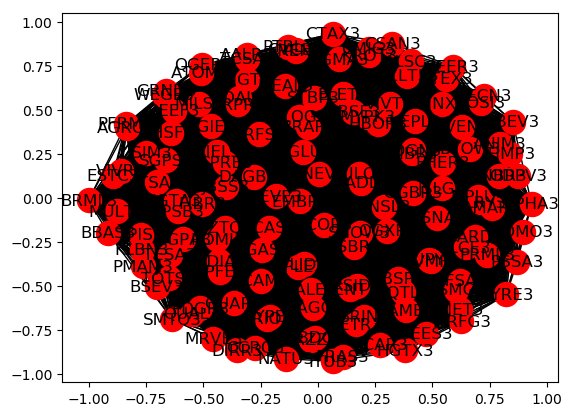

In [154]:
nx.draw_networkx(G2,with_labels=True)
plt.show()

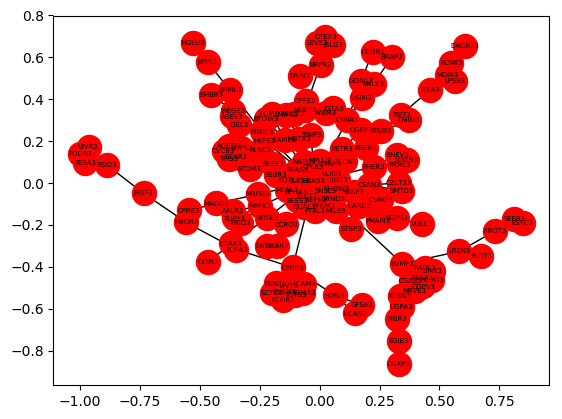

In [155]:
plt.close('all')
TT2 = nx.minimum_spanning_tree(G2,algorithm='prim')
pos = nx.spring_layout(TT2)
nx.draw_networkx(TT2,pos,with_labels=True,font_size=5)
plt.show()
#TT2[0]

In [156]:
nx.write_graphml(TT2,'bosta2.graphml')
#TT2
type(TT2)

networkx.classes.graph.Graph

In [97]:
G = nx.from_numpy_matrix(Distances)
TT = nx.minimum_spanning_tree(G,algorithm='prim')
GG =G
for e in GG.edges(data=True):
    print(e)
    if GG.get_edge_data(*e)['weight']<1e-5:
        G.remove_edge(*e)

(0, 0, {'weight': 2.1073424255447017e-08})


TypeError: remove_edge() takes 3 positional arguments but 4 were given

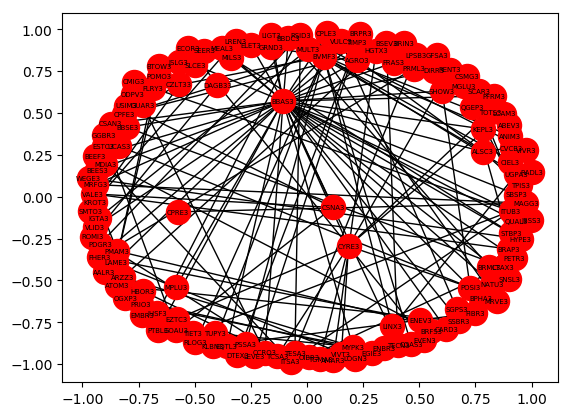

In [148]:
plt.close('all')
G_labels={}
for i in range(len(df_raw_data3.columns.values)):
    G_labels[i]=str(df_raw_data3.columns.values[i])
pos = nx.spring_layout(TT,k=2)
#pos = nx.graph(TT)
nx.draw_networkx(TT,pos,labels=G_labels,font_size=5)
#nx.draw_networkx_labels(TT,pos=nx.spring_layout(TT),labels=G_labels,font_size=10)
plt.show()
nx.write_graphml(TT,'bosta.graphml')

In [20]:
df_raw_data3.columns.values
G_labels={}
for i in range(len(df_raw_data3.columns.values)):
    G_labels[i]=str(df_raw_data3.columns.values[i])
